# Intro

Continuing my work from Dengue Study V1 and V2. In this notebook, I will refine the models. Some ideas to implement:

* Weighted loss functions: apply more weight to the beginning of the forecast (Done!)
  * Previous results could got even get the day 1 forecast reasonably, which is surprising, because it should be very close to the previous day
  * Could applying weighting to the loss function, with the day one forecast mattering more, help?
* Better displays of the results (New plot looking at n-week forecast)
* Early stopping


Some more things to add:
* Some measures of feature importance
* Add the time of year as a feature? That may be complicated by the issues in the data set. Could get it from week_start_date, map it to day of year?



In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [2]:
# Some stuff from the Feature Engineering Course:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Some relevant info from google: female mosquito lifetime is 42-56 days, male is 10
That is approximately 7 weeks for female mosquitos.



In [3]:
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True,infer_datetime_format=True)
dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True,infer_datetime_format=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True,infer_datetime_format=True)


In [4]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


In [5]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()

# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']


    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])

list_of_frames=[
    dengue_features_sj_train,
    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
    dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)

    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


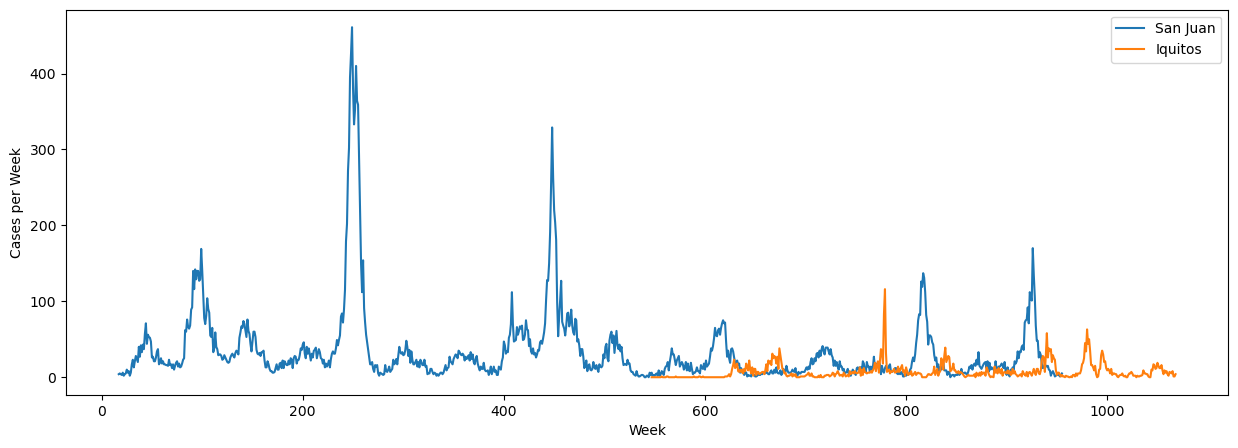

In [6]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('cases_data.png')

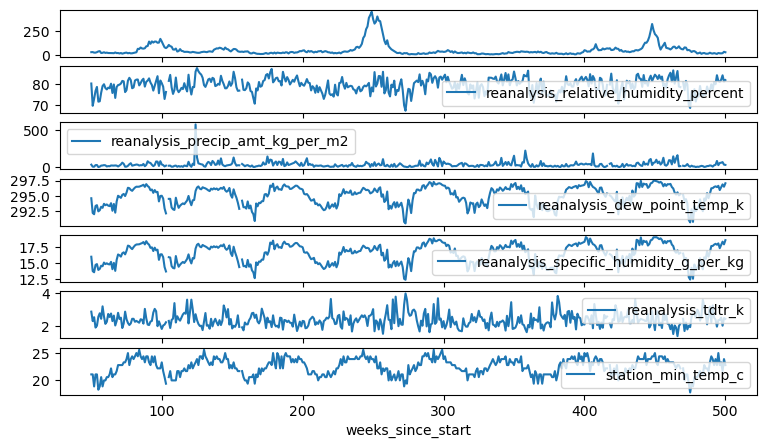

In [7]:
start_week=50
end_week=500

#features_to_plot=['reanalysis_relative_humidity_percent',
#                  'reanalysis_precip_amt_kg_per_m2',
#                  'reanalysis_dew_point_temp_k',
#                  'reanalysis_specific_humidity_g_per_kg',
#                  'reanalysis_tdtr_k',
#                 'station_min_temp_c']
#ax=dengue_labels_sj_train.loc[start_week:end_week,['total_cases']].plot(figsize=(15,5))
#dengue_features_sj_train.loc[start_week:end_week,features_to_plot].plot(ax=ax)
#plt.savefig('test_feature_cmp_sj.png')

features_to_plot=['total_cases',
                  'reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, sharex=True, sharey=False)
for i in range(len(features_to_plot)):
    feat_to_plot = features_to_plot[i]
    if feat_to_plot == 'total_cases':
        figsize=(9,5)
        ax1 = plt.subplot2grid((len(features_to_plot), 1), (0, 0), colspan=1)
        dengue_labels_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax1,figsize=figsize)
    else:
        ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
        dengue_features_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax2,label=feat_to_plot)
        ax2.legend()


/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


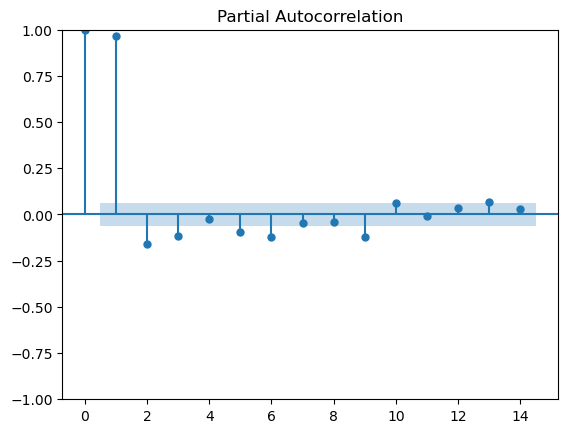

In [8]:
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('cases_sj_pacf.png')

# Variables


In [9]:
# Averaging Vegetation Index data
ndvi_features=['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']

dengue_features_sj_train_ndvi_mean=dengue_features_sj_train[ndvi_features].mean(axis=1)
dengue_features_sj_train['ndvi_mean']=dengue_features_sj_train_ndvi_mean

In [10]:
precip_variable='reanalysis_sat_precip_amt_mm'
ndvi_variable='ndvi_mean'
rel_hum_variable='reanalysis_relative_humidity_percent'
dew_point_variable='reanalysis_dew_point_temp_k'
mean_temp_variable='reanalysis_avg_temp_k'

variables_of_interest=[precip_variable,ndvi_variable,
                       rel_hum_variable,dew_point_variable,
                       mean_temp_variable]
# for labelling
varnames_of_interest=['precip','ndvi','rel_hum','dew_pt','mean_temp']
vartitles_of_interest=['Precipitation','Vegetation Index','Relative Humidity','Dew Point','Mean Temp']

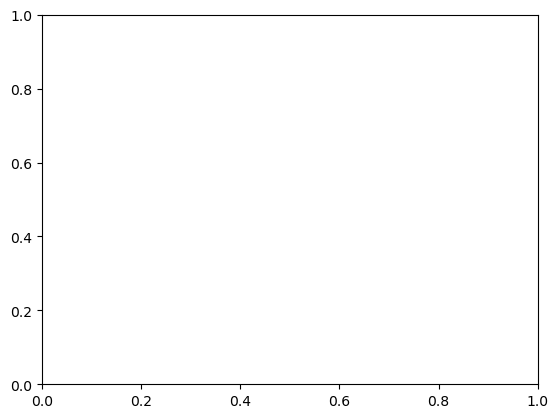

In [11]:
smoothed_features=[]
for i in range(len(variables_of_interest)):
    variable=variables_of_interest[i]
    varname=varnames_of_interest[i]
    vartitle=vartitles_of_interest[i]
    variable_rolling = dengue_features_sj_train[variable].rolling(window=5,center=False).mean()
    smoothed_features.append(variable_rolling)
    ax = dengue_features_sj_train[variable].plot(label=vartitle)
    variable_rolling.plot(ax=ax,label="%s (smoothed)" % (vartitle))
    ax.legend()
    #ax.set_ylabel(vartitle_of_interest[i])
    plt.savefig("variable_%s_smoothed.png" % (varname))
    ax.clear()

# Section: Target and Feature Lags

In [12]:
y_sj=dengue_labels_sj_train['total_cases']

In [13]:
#target_lag_number = 12
target_lag_number = 104

y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=target_lag_number)

In [14]:
# can use code from Time Series course

n_lags=24

lags_list=[]
lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(dengue_features_sj_train[variables_of_interest[i]],
                       lags=n_lags,name=varnames_of_interest[i])
    lags_list.append(var_lags)
    lags_list_no_target.append(var_lags)
    
# add target lags
lags_list.append(y_sj_lags)
    
smoothed_lags_list=[]
smoothed_lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(smoothed_features[i],
                       lags=n_lags,name="%s_smooth" % (varnames_of_interest[i]))
    print(type(var_lags))
    smoothed_lags_list.append(var_lags)
    smoothed_lags_list_no_target.append(var_lags)

smoothed_lags_list.append(y_sj_lags)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [15]:
y_sj_deriv=dengue_labels_sj_train['total_cases']-y_sj_lags['y_lag_1']

In [16]:
y_sj_deriv_smooth_gauss_mean=y_sj_deriv.rolling(window=7,center=False,win_type='gaussian').mean(std=3)
y_sj_deriv_smooth_const_mean=y_sj_deriv.rolling(window=7,center=False).mean(std=3)


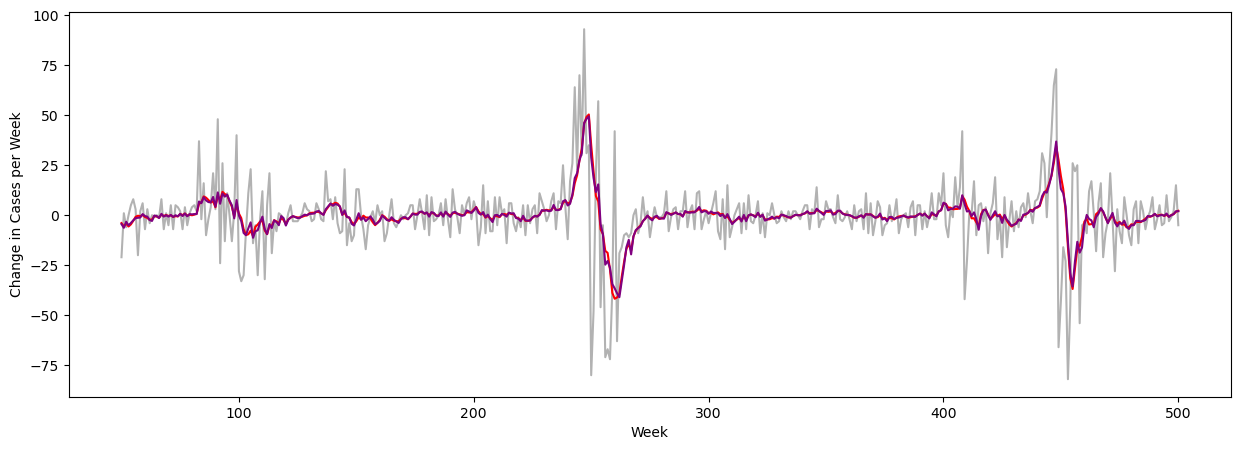

In [17]:
START=50
END=500
ax=y_sj_deriv.loc[START:END].plot(figsize=(15,5),color='black',alpha=0.3)
y_sj_deriv_smooth_gauss_mean.loc[START:END].plot(ax=ax,label='Gaussian Smooth',color='red')
y_sj_deriv_smooth_const_mean.loc[START:END].plot(ax=ax,label='Flat Window',color='purple')
ax.set(xlabel="Week",ylabel="Change in Cases per Week")
plt.savefig("deriv_smoothing.png")

In [18]:
#print(type(y_sj_deriv_smooth_gauss_mean))
#y_sj_deriv_smooth_gauss_mean_frame=pd.DataFrame(y_sj_deriv_smooth_gauss_mean.shift(1),columns=['target_deriv_smooth_gauss_mean'])
#print(y_sj_deriv_smooth_gauss_mean_frame)
#y_sj_deriv_smooth_const_mean_frame=pd.DataFrame(y_sj_deriv_smooth_const_mean.shift(1),columns=['target_deriv_smooth_const_mean'])
#print(y_sj_deriv_smooth_const_mean_frame)

y_sj_deriv_smooth_gauss_mean_frame=pd.DataFrame(y_sj_deriv_smooth_gauss_mean,columns=['target_deriv_smooth_gauss_mean'])
#print(y_sj_deriv_smooth_gauss_mean_frame)
y_sj_deriv_smooth_const_mean_frame=pd.DataFrame(y_sj_deriv_smooth_const_mean,columns=['target_deriv_smooth_const_mean'])
#print(y_sj_deriv_smooth_const_mean_frame)

print(y_sj_deriv_smooth_gauss_mean_frame.head(15))
# need to shift by one to make sure it doesn't include the current or future information
# Or, apply make lags on this.



                   target_deriv_smooth_gauss_mean
weeks_since_start                                
17                                            NaN
18                                            NaN
19                                            NaN
20                                            NaN
21                                            NaN
22                                            NaN
23                                            NaN
24                                       0.049768
25                                       0.553044
26                                       0.444298
27                                       0.744503
28                                      -0.122709
29                                       0.395554
30                                       1.231134
31                                       2.094603


In [19]:
target_deriv_smooth_gauss_lags=make_lags(y_sj_deriv_smooth_gauss_mean_frame['target_deriv_smooth_gauss_mean'],
                                         lags=n_lags,name='target_deriv_smooth_gauss_mean')
target_deriv_smooth_const_lags=make_lags(y_sj_deriv_smooth_const_mean_frame['target_deriv_smooth_const_mean'],
                                         lags=n_lags,name='target_deriv_smooth_const_mean')



In [20]:
print(type(target_deriv_smooth_const_lags))
print(type(target_deriv_smooth_gauss_lags))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [21]:
#lags_list

# Adding the derivatives to the lag lists
lags_list.append(target_deriv_smooth_const_lags)


In [22]:
for lag_feature in lags_list:
    print(type(lag_feature))
    for col in lag_feature.columns:
        print(col)

<class 'pandas.core.frame.DataFrame'>
precip_lag_1
precip_lag_2
precip_lag_3
precip_lag_4
precip_lag_5
precip_lag_6
precip_lag_7
precip_lag_8
precip_lag_9
precip_lag_10
precip_lag_11
precip_lag_12
precip_lag_13
precip_lag_14
precip_lag_15
precip_lag_16
precip_lag_17
precip_lag_18
precip_lag_19
precip_lag_20
precip_lag_21
precip_lag_22
precip_lag_23
precip_lag_24
<class 'pandas.core.frame.DataFrame'>
ndvi_lag_1
ndvi_lag_2
ndvi_lag_3
ndvi_lag_4
ndvi_lag_5
ndvi_lag_6
ndvi_lag_7
ndvi_lag_8
ndvi_lag_9
ndvi_lag_10
ndvi_lag_11
ndvi_lag_12
ndvi_lag_13
ndvi_lag_14
ndvi_lag_15
ndvi_lag_16
ndvi_lag_17
ndvi_lag_18
ndvi_lag_19
ndvi_lag_20
ndvi_lag_21
ndvi_lag_22
ndvi_lag_23
ndvi_lag_24
<class 'pandas.core.frame.DataFrame'>
rel_hum_lag_1
rel_hum_lag_2
rel_hum_lag_3
rel_hum_lag_4
rel_hum_lag_5
rel_hum_lag_6
rel_hum_lag_7
rel_hum_lag_8
rel_hum_lag_9
rel_hum_lag_10
rel_hum_lag_11
rel_hum_lag_12
rel_hum_lag_13
rel_hum_lag_14
rel_hum_lag_15
rel_hum_lag_16
rel_hum_lag_17
rel_hum_lag_18
rel_hum_lag_19
rel_

In [23]:
dengue_features_sj_train_lags=pd.concat(lags_list, axis=1)
dengue_features_no_target_sj_train_lags=pd.concat(lags_list_no_target, axis=1)

dengue_smoothed_features_sj_train_lags=pd.concat(smoothed_lags_list, axis=1)
dengue_smoothed_features_no_target_sj_train_lags=pd.concat(smoothed_lags_list_no_target, axis=1)

In [24]:


X_lags_no_target_for_mi=dengue_features_no_target_sj_train_lags.dropna()
X_lags_for_mi=dengue_features_sj_train_lags.dropna()
#print(X_lags_no_target_for_mi)

(y_lags_no_target_for_mi,X_lags_no_target_for_mi) = y_sj.align(X_lags_no_target_for_mi, join='inner', axis=0)
(y_lags_for_mi,X_lags_for_mi) = y_sj.align(X_lags_for_mi, join='inner', axis=0)
print(X_lags_no_target_for_mi.shape)
print(y_lags_no_target_for_mi.shape)

mi_scores = make_mi_scores(X_lags_no_target_for_mi, y_lags_no_target_for_mi, 'auto')
mi_with_target_scores = make_mi_scores(X_lags_for_mi, y_lags_for_mi, 'auto')

(675, 120)
(675,)


In [25]:
print("Mutual Information Scores without target info:")
print(mi_scores.head(24))
print("Mutual Information Scores, including target-derived features")
print(mi_with_target_scores.head(25))

Mutual Information Scores without target info:
dew_pt_lag_8        0.259433
dew_pt_lag_6        0.242868
dew_pt_lag_10       0.233575
dew_pt_lag_11       0.229592
dew_pt_lag_9        0.225653
dew_pt_lag_7        0.219247
mean_temp_lag_8     0.216037
mean_temp_lag_10    0.214903
dew_pt_lag_13       0.209682
mean_temp_lag_5     0.201356
mean_temp_lag_7     0.198994
mean_temp_lag_9     0.193413
dew_pt_lag_4        0.192352
mean_temp_lag_6     0.187063
dew_pt_lag_12       0.183940
mean_temp_lag_12    0.172943
mean_temp_lag_13    0.169626
dew_pt_lag_3        0.161636
dew_pt_lag_5        0.159873
mean_temp_lag_11    0.147035
dew_pt_lag_2        0.139543
rel_hum_lag_8       0.134972
dew_pt_lag_1        0.131240
mean_temp_lag_4     0.129599
Name: MI Scores, dtype: float64
Mutual Information Scores, including target-derived features
y_lag_1                                  1.005196
y_lag_2                                  0.806160
y_lag_3                                  0.693286
y_lag_4       

Text(0.5, 0, 'Week Lag n')

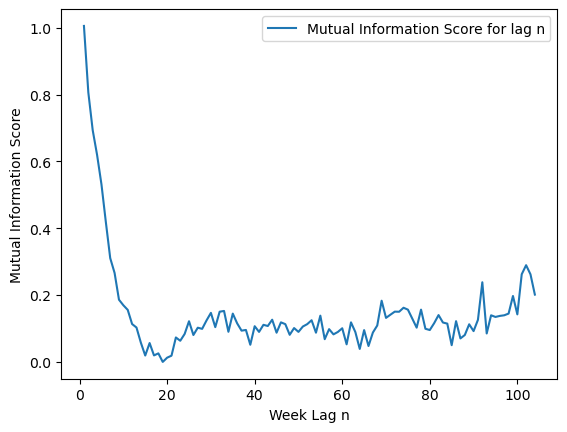

In [26]:
# Plot MI scores for y_lag_n
# target_lag_number
y_lag_n = []
y_lag_mi_scores = []
for i in range(1,target_lag_number+1):
    y_lag_n.append(i)
    y_lag_mi_scores.append(mi_with_target_scores[f'y_lag_{i}'])
    
fig,ax = plt.subplots()
plt.plot(y_lag_n,y_lag_mi_scores,label="Mutual Information Score for lag n")
plt.legend()
ax.set_ylabel('Mutual Information Score')
ax.set_xlabel('Week Lag n')


In [27]:
from sklearn.model_selection import train_test_split

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #preds.index = pd.period_range(start=date, periods=len(preds))
        preds.index = range(date,date+len(preds))
        preds.plot(ax=ax,label=f"Forecast from {date}")
    return ax


In [28]:
# plot the nstep step
# i.e. plot the forecast for nsteps ahead
def plot_nth_step(y, nstep=1,ax=None,palette_kwargs=None):
    #palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #if palette_kwargs is not None:
    #    palette_kwargs_.update(palette_kwargs)
    #palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    #ax.set_prop_cycle(plt.cycler('color', palette))
    
    # might be shift(-nstep)
    preds=y.iloc[:,nstep].shift(nstep)
    preds.plot(ax=ax,label=f"Forecast from {nstep} weeks earlier")
    return ax

In [29]:
target_forecast_steps=20
y_sj_multistep = make_multistep_target(y_sj,steps=target_forecast_steps).dropna()

# Defining Inputs and Models

In [30]:
# each model may require different X,y
# especially based on rows we remove

list_X=[]
list_y=[]

model_list=[]
model_labels=[]
model_titles=[]

X_train_list=[]
X_valid_list=[]
y_train_list=[]
y_valid_list=[]

# Defining Models

In [31]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [32]:
print("Available columns:")
for col in dengue_features_sj_train_lags.columns:
    print(col)

Available columns:
precip_lag_1
precip_lag_2
precip_lag_3
precip_lag_4
precip_lag_5
precip_lag_6
precip_lag_7
precip_lag_8
precip_lag_9
precip_lag_10
precip_lag_11
precip_lag_12
precip_lag_13
precip_lag_14
precip_lag_15
precip_lag_16
precip_lag_17
precip_lag_18
precip_lag_19
precip_lag_20
precip_lag_21
precip_lag_22
precip_lag_23
precip_lag_24
ndvi_lag_1
ndvi_lag_2
ndvi_lag_3
ndvi_lag_4
ndvi_lag_5
ndvi_lag_6
ndvi_lag_7
ndvi_lag_8
ndvi_lag_9
ndvi_lag_10
ndvi_lag_11
ndvi_lag_12
ndvi_lag_13
ndvi_lag_14
ndvi_lag_15
ndvi_lag_16
ndvi_lag_17
ndvi_lag_18
ndvi_lag_19
ndvi_lag_20
ndvi_lag_21
ndvi_lag_22
ndvi_lag_23
ndvi_lag_24
rel_hum_lag_1
rel_hum_lag_2
rel_hum_lag_3
rel_hum_lag_4
rel_hum_lag_5
rel_hum_lag_6
rel_hum_lag_7
rel_hum_lag_8
rel_hum_lag_9
rel_hum_lag_10
rel_hum_lag_11
rel_hum_lag_12
rel_hum_lag_13
rel_hum_lag_14
rel_hum_lag_15
rel_hum_lag_16
rel_hum_lag_17
rel_hum_lag_18
rel_hum_lag_19
rel_hum_lag_20
rel_hum_lag_21
rel_hum_lag_22
rel_hum_lag_23
rel_hum_lag_24
dew_pt_lag_1
dew_pt_lag_

In [33]:
list_X=[]
list_y=[]

model_list=[]
model_labels=[]
model_titles=[]

X_train_list=[]
X_valid_list=[]
y_train_list=[]
y_valid_list=[]



n_estimators=30
n_jobs=4

model_labels.append("RegChain1_Target_Only")
model_titles.append("Regressor Chain 1 Target Only")
model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model_1)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("RegChain1_Target_Only_More_Lags")
model_titles.append("Regressor Chain 1 Target Only More Lags")
model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model_1)


features_for_model=[]
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)


local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)










model_labels.append("RegChain1_Dew_Precip")
model_titles.append("Regressor Chain 1 Dew Precip")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12'
                   ]


local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

model_labels.append("RegChain1_Dew_Temp_Hum")
model_titles.append("Regressor Chain 1 Dew Temp Hum")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)


features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11',
                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("RegChain1_Dew_Temp_Hum_Precip")
model_titles.append("Regressor Chain 1 Dew Temp Hum Precip")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11',
                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11',
                    'precip_lag_2','precip_lag_3','precip_lag_4','precip_lag_5',
                    'precip_lag_6','precip_lag_7','precip_lag_8','precip_lag_9'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

In [34]:
# Neural Network models

# need to make multiple outputs.

from tensorflow import keras
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
# New: Define my NNs with a Class
# getting this to work is still beyond me
class MyNN1(Model):
    def __init__(self,input_shape, *args, **kwargs):
        #super(MyNN1, self).__init__()
        #my_init = keras.initializers.glorot_uniform(seed=1)
        super().__init__(*args, **kwargs)
        
        #self.input_layer = Input(input_shape,name='input')
        self.layer1 = BatchNormalization()
        self.layer2 = Dense(20, activation='relu',name='layer2')
        #self.layer3 = BatchNormalization()
        self.layer3 = Dense(20, activation='relu',name='layer3')
        self.layer4 = Dense(20, activation='relu',name='layer4')
        self.layer5 = Dense(20, activation='sigmoid',name='layer5')
        self.layer6 = Dense(20, activation=None,name='layer6')

    
    # Getting this error: ValueError: Input 0 of layer "layer2" is incompatible with the layer: 
    #.      expected min_ndim=2, found ndim=1. Full shape received: (22,)
    
    def call(self, inputs):
        #x = self.input_layer(inputs)
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x




In [36]:
def BuildMyNN(input_shape,n_outputs,name):
    inputs = Input(shape=(local_X.shape[1],),name='input')
    #print(inputs)

    x = BatchNormalization()(inputs)
    x = Dense(200, activation='relu',name='layer2')(x)
    x = Dropout(0.4)(x)
    x = Dense(200, activation='sigmoid',name='layer3')(x)
    x = Dropout(0.4)(x)
    x = Dense(200, activation='relu',name='layer4')(x)
    #x = Dense(20, activation=None,name='layer5')(x)
    # FIXME verifying that the 20 has to be set to the output shape
    x = Dense(n_outputs, activation=None,name='output')(x)

#    x = BatchNormalization()(inputs)
#    x = Dense(20, activation='relu',name='layer2')(x)
#    x = BatchNormalization()(x)
#    x = Dense(20, activation='relu',name='layer3')(x)
#    x = Dense(20, activation='sigmoid',name='layer4')(x)
#    x = Dense(20, activation=None,name='layer5')(x)

    
    model = Model(inputs=inputs,outputs=x)
    return model

# Custom Loss Function

Want to weight more strongly the early (1-week, 2-week, etc) losses.
A simple, natural function to do this would be an exponential decay. To make sure that there is still some weighting on the farther out forecasts, let's use a decay to a constant.

$$
f(x) = (1 + \alpha e^{-\lambda (x - 1)})
$$

The hyperparameter $\lambda$ gives the decay of this enhanced loss, in units of weeks. For every week after the 1-week losses, the added weight decreases by a factor of $e^{-\lambda}$. The half-life of this decay is given by $\tau_{1/2} = \frac{\ln(2)}{\lambda} \approx \frac{0.693}{\lambda}$ 

The hyperparameter $\alpha$ gives the strength of the enhancement for the 1-week forecast (and overall scaling for the enhancement).

Note: in the implementation, there will be no -1 shift, as the first (index 0) output column is already the 1-week forecast.

It seems this could also be done with the loss_weights option in compile()

In [37]:
# New: Define Custom Loss Functions
# guide https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b
# https://stackoverflow.com/questions/45480820/keras-how-to-get-tensor-dimensions-inside-custom-loss
import tensorflow.keras.backend as K

custom_loss_alpha = 15

# start with halflife for readability
custom_loss_halflife = 1
custom_loss_lambda = np.log(2) / custom_loss_halflife

# mse with exponential decay
def custom_loss_mse_weighted(y_true, y_pred):
    # y_true and y_pred should be matrices of (batch_size * outputs)
    # compute square error
    loss = K.square(y_pred - y_true)  # (batch_size, output_size)
    
    output_dim = K.int_shape(y_true)[1]
    weights = np.ones(output_dim)
    weights_enhancement = np.arange(output_dim)
    weights_enhancement = -custom_loss_lambda * weights_enhancement
    weights_enhancement = custom_loss_alpha * np.exp(weights_enhancement)
    weights = weights + weights_enhancement
    
    # multiplying the values with weights along batch dimension
    loss = loss * weights          # (batch_size, output_size)
    
    # summing all loss values along batch dimension 
    loss = K.sum(loss, axis=1)        # (batch_size,)
    
    return loss

# log_mse with exponential decay
def custom_loss_msle_weighted(y_true, y_pred):
    # y_true and y_pred should be matrices of (batch_size * outputs)
    # compute square error
    # FIXME switch to keras log function
    # FIXME should a mean be taken somewhere? A mean avoiding nans?
    # But do I want to ignore nans? I should be punishing them.
    #   maybe fillnan with a bad value? But that would have zero derivative
    
    # FIXME do we need to take the absolute value in case y_pred goes negative?
    # increasing from standard offset of 1 to better avoid log(0)
    msle_offset = 10
    
    loss = K.square(K.log(msle_offset+y_pred) - K.log(msle_offset+y_true))  # (batch_size, output_size)
    
    output_dim = K.int_shape(y_true)[1]
    weights = np.ones(output_dim)
    weights_enhancement = np.arange(output_dim)
    weights_enhancement = -custom_loss_lambda * weights_enhancement
    weights_enhancement = custom_loss_alpha * np.exp(weights_enhancement)
    weights = weights + weights_enhancement
    
    # multiplying the values with weights along batch dimension
    loss = loss * weights          # (batch_size, output_size)
    
    # summing both loss values along batch dimension 
    loss = K.sum(loss, axis=1)        # (batch_size,)
    
    return loss


In [38]:
# NN Model 1


# temporarily resetting lists for testing
if (False):
    list_X=[]
    list_y=[]

    model_list=[]
    model_labels=[]
    model_titles=[]

    X_train_list=[]
    X_valid_list=[]
    y_train_list=[]
    y_valid_list=[]

    
#nn_loss_choice='mean_squared_logarithmic_error'
nn_loss_choice='mse'

nn_loss_choice_a = 'mse'
nn_loss_choice_b = custom_loss_mse_weighted
nn_loss_choice_c='mean_squared_logarithmic_error'
nn_loss_choice_d = custom_loss_msle_weighted

# would some loss options emphasize the peaked outbreaks better?
#Should the different time step outputs have different losses?
    
# use a,b,c,d for loss functions
    
    
# Dew
model_labels.append("NN_1a_Dew_Auto")
model_titles.append("Neural Network 1a Dew Auto")
#features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
#                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
#                    'dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
#                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
#                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
#                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
#                   ]
features_for_model=['dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]
# adding in all y_lag 
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)
#model = MyNN1((local_X.shape[1],),name = "NN_1a_Dew_Auto")
#model.build(input_shape=(local_X.shape[1],))
#model = Model(inputs=inputs,outputs=x)
#model = Model(inputs=inputs,outputs=output_layers)


model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_1a_Dew_Auto")
model.compile(loss=nn_loss_choice_a,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn1a.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)




# Now with weighted training
model_labels.append("NN_1b_Dew_Auto")
model_titles.append("Neural Network 1b Dew Auto")

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_1b_Dew_Auto")
model.compile(loss=nn_loss_choice_b,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn1b.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("NN_1c_Dew_Auto")
model_titles.append("Neural Network 1c Dew Auto")

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_1c_Dew_Auto")
model.compile(loss=nn_loss_choice_c,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn1c.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)




# Now with weighted training
model_labels.append("NN_1d_Dew_Auto")
model_titles.append("Neural Network 1d Dew Auto")

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_1d_Dew_Auto")
model.compile(loss=nn_loss_choice_d,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn1d.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)






# ====================================================================


model_labels.append("NN_2_Dew_Deriv")
model_titles.append("Neural Network 2 Dew Deriv")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'target_deriv_smooth_const_mean_lag_1',
                    'target_deriv_smooth_const_mean_lag_2',
                    'target_deriv_smooth_const_mean_lag_3',
                    'target_deriv_smooth_const_mean_lag_4',
                    'target_deriv_smooth_const_mean_lag_5',
                    'dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')
 
model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_2_Dew_Deriv_Auto")
model.compile(loss=nn_loss_choice,optimizer='adam')

print(model)
model.summary()
keras.utils.plot_model(model, f'model_nn_{model_labels[-1]}.png', show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)


# ====================================================================

model_labels.append("NN_3a_Dew_Precip")
model_titles.append("Neural Network 3a Dew Precip")
features_for_model=['dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12'
                   ]
# adding in all y_lag 
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_3a_Dew_Precip_Deriv_Auto")
model.compile(loss=nn_loss_choice_a,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn3a.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)



model_labels.append("NN_3b_Dew_Precip")
model_titles.append("Neural Network 3b Dew Precip")
features_for_model=['dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12'
                   ]
# adding in all y_lag 
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_3b_Dew_Precip_Deriv_Auto")
model.compile(loss=nn_loss_choice_b,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn3b.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)




model_labels.append("NN_3c_Dew_Precip")
model_titles.append("Neural Network 3c Dew Precip")
features_for_model=['dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12'
                   ]
# adding in all y_lag 
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_3c_Dew_Precip_Deriv_Auto")
model.compile(loss=nn_loss_choice_c,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn3c.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("NN_3d_Dew_Precip")
model_titles.append("Neural Network 3d Dew Precip")
features_for_model=['dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12'
                   ]
# adding in all y_lag 
for col in dengue_features_sj_train_lags.columns:
    if 'y_lag' in col:
        features_for_model.append(col)

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_3d_Dew_Precip_Deriv_Auto")
model.compile(loss=nn_loss_choice_d,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn3a.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)







#                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
#                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11',

# ====================================================================

model_labels.append("NN_4_Dew_Precip_Hum")
model_titles.append("Neural Network 4 Dew Precip Humid")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'precip_lag_1','precip_lag_2','precip_lag_3',
                    'precip_lag_4','precip_lag_5','precip_lag_6',
                    'precip_lag_7','precip_lag_8','precip_lag_9',
                    'precip_lag_10','precip_lag_11','precip_lag_12',
                    'rel_hum_lag_1','rel_hum_lag_2','rel_hum_lag_3',
                    'rel_hum_lag_4','rel_hum_lag_5','rel_hum_lag_6',
                    'rel_hum_lag_7','rel_hum_lag_8','rel_hum_lag_9',
                    'rel_hum_lag_10','rel_hum_lag_11','rel_hum_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

inputs = Input(shape=(local_X.shape[1],),name='input')

model = BuildMyNN((local_X.shape[1],),target_forecast_steps,"NN_4_Dew_Precip_Hum_Deriv_Auto")
model.compile(loss=nn_loss_choice,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn4.png", show_shapes=True,show_layer_activations=False)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)

116
KerasTensor(type_spec=TensorSpec(shape=(None, 116), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 116)]             0         
                                                                 
 batch_normalization (BatchN  (None, 116)              464       
 ormalization)                                                   
                                                                 
 layer2 (Dense)              (None, 200)               23400     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 layer3 (Dense)              (None, 200)               40200     
                                                  

# Split the data
Also, we can choose to standardize the data here (so we can make sure to just get the mean and std from the training sets)

In [39]:
# Switch to standardize all inputs
enable_standardize_all=True

test_size=400
for i in range(len(list_X)):
    local_X = list_X[i]
    local_y = list_y[i]
    local_y, local_X = local_y.align(local_X, join='inner', axis=0)
    X_train, X_valid, y_train, y_valid = train_test_split(local_X, local_y, test_size=test_size, shuffle=False)

    if (enable_standardize_all):
        X_valid = (X_valid - X_train.mean())/X_train.std()
        X_train = (X_train - X_train.mean())/X_train.std()
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    y_train_list.append(y_train)
    y_valid_list.append(y_valid)

# Run the Fits

In [40]:
# For fitting methods that give histories
fit_histories=[]
fit_history_labels=[]
fit_history_indices=[]

# Settings
verbose_nn = 0
# FIXME increase epochs after debugging
num_epochs=400
#num_epochs=800
batch_size=10
#batch_size=50

es_patience = 20

# Do I have to build an EarlyStopping object for each model?
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)
# history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])



for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    
    X_valid=X_valid_list[i]
    y_valid=y_valid_list[i]
    # can add choices based on tags in the model_label
    # maybe add NN to the beginning
    print(f'Fitting model {model_label}')
    #print(y_train.head())
  
    if model_label[0:2] == "NN":
        print("I think this is a Neural Net model. Fitting accordingly.")


        history = model.fit(X_train,y_train,epochs=num_epochs,validation_data=(X_valid, y_valid),batch_size=batch_size,verbose=verbose_nn,callbacks=[es])

        #history = model.fit(X_train,y_train,epochs=num_epochs,batch_size=52,verbose=0)
        #history = model.fit(X_train,y_train)
        fit_histories.append(history)
        fit_history_labels.append(model_label)
        fit_history_indices.append(i)
    else:
    ##history = model.fit(X, {'cont_out': Y, 'cat_out': Z}, epochs=10, batch_size=8)
    
        model.fit(X_train,y_train)
    #history = model.fit(X_train,y_train)
    #fit_histories.append(history)
    #fit_history_labels.append(model_label)
    #fit_history_indices.append(i)
    #print(type(history))
    print(f'  Finished fitting model {model_label}')
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_valid, y_valid),
#    batch_size=256,
#    epochs=100,
#    verbose=0,
#)


# Show the learning curves
#history_df = pd.DataFrame(history.history)
#history_df.loc[:, ['loss', 'val_loss']].plot();


Fitting model RegChain1_Target_Only
  Finished fitting model RegChain1_Target_Only
Fitting model RegChain1_Target_Only_More_Lags
  Finished fitting model RegChain1_Target_Only_More_Lags
Fitting model RegChain1_Dew_Precip
  Finished fitting model RegChain1_Dew_Precip
Fitting model RegChain1_Dew_Temp_Hum
  Finished fitting model RegChain1_Dew_Temp_Hum
Fitting model RegChain1_Dew_Temp_Hum_Precip
  Finished fitting model RegChain1_Dew_Temp_Hum_Precip
Fitting model NN_1a_Dew_Auto
I think this is a Neural Net model. Fitting accordingly.
Epoch 29: early stopping
  Finished fitting model NN_1a_Dew_Auto
Fitting model NN_1b_Dew_Auto
I think this is a Neural Net model. Fitting accordingly.
Epoch 32: early stopping
  Finished fitting model NN_1b_Dew_Auto
Fitting model NN_1c_Dew_Auto
I think this is a Neural Net model. Fitting accordingly.
Epoch 21: early stopping
  Finished fitting model NN_1c_Dew_Auto
Fitting model NN_1d_Dew_Auto
I think this is a Neural Net model. Fitting accordingly.
Epoch 35: 

Giving fitting history information for NN_1a_Dew_Auto
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_1b_Dew_Auto
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_1c_Dew_Auto
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_1d_Dew_Auto
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_2_Dew_Deriv
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_3a_Dew_Precip
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_3b_Dew_Precip
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_3c_Dew_Precip
<class 'keras.ca

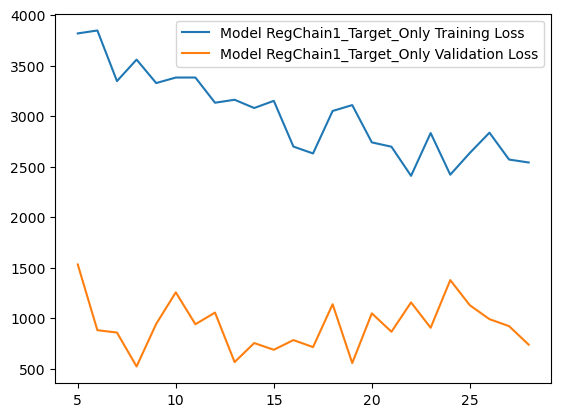

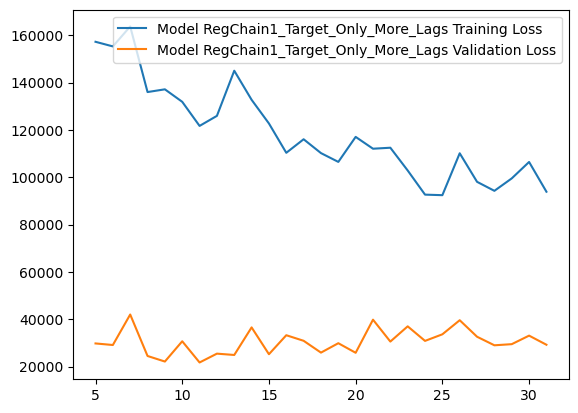

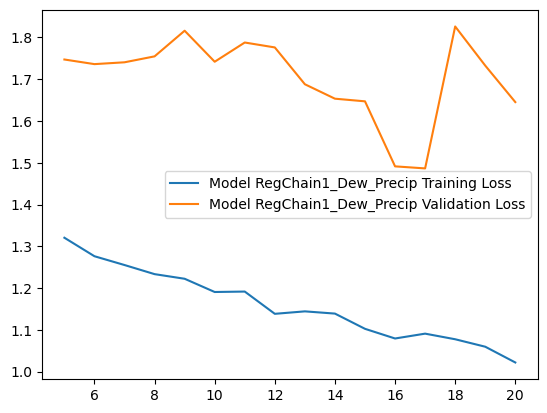

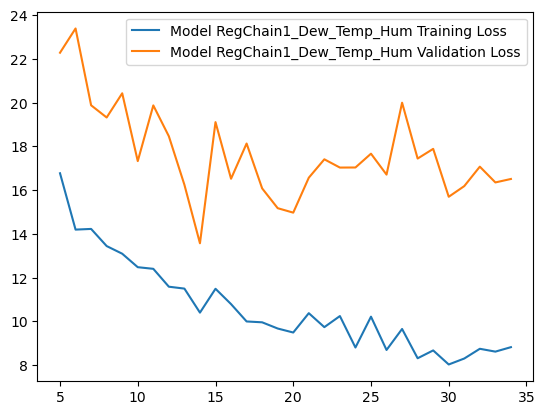

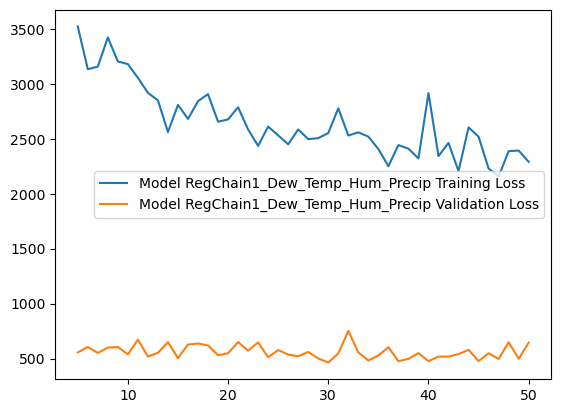

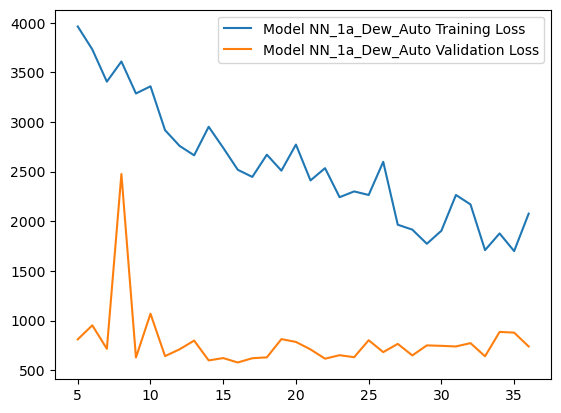

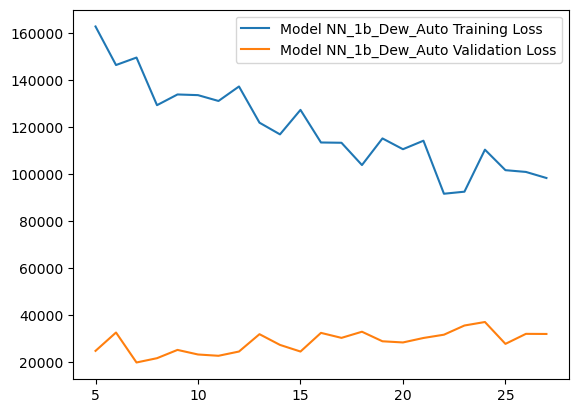

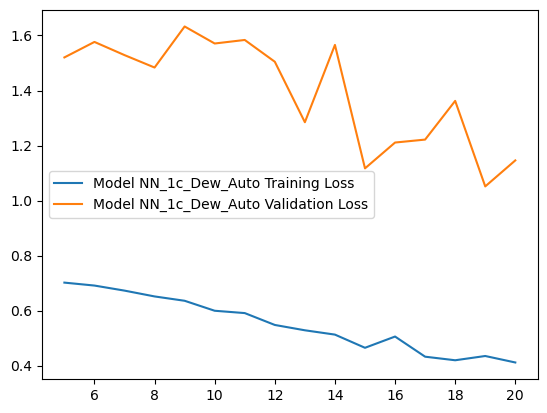

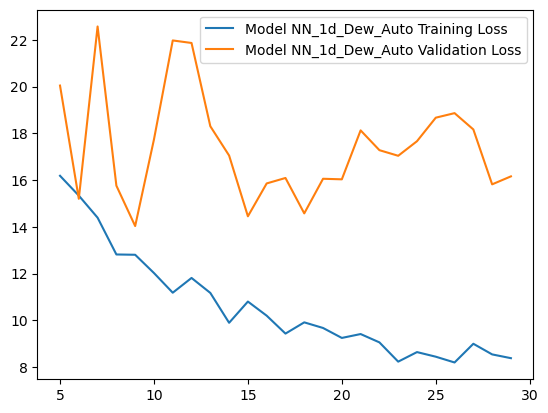

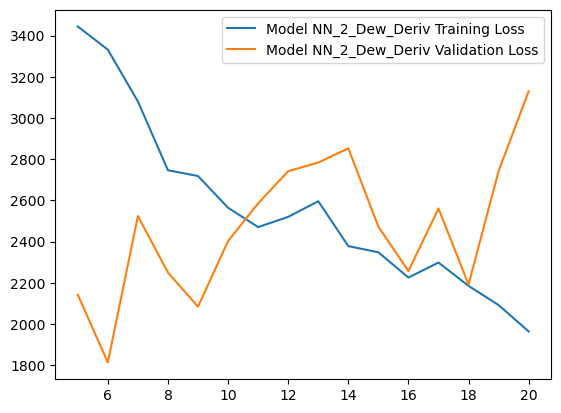

In [41]:

for i in range(len(fit_history_indices)):
    history = fit_histories[i]
    label=fit_history_labels[i]
    model_label = model_labels[i]
    fit_index=fit_history_indices[i] # global model index
    print(f'Giving fitting history information for {label}')
    print(type(history))
    print(history)
    history_df = pd.DataFrame(history.history)
    print(history_df.columns)
    # Start the plot at epoch 5
    history_df.loc[5:, ['loss', 'val_loss']].plot()
    plt.legend([f'Model {model_label} Training Loss',f'Model {model_label} Validation Loss'])
    plt.savefig(f'model_{label}_fit_history.png')
    #history_df.loc[5:, ['y_step_10_loss', 'val_y_step_10_loss']].plot()
    #plt.legend(['Training Loss (Step 10)','Validation Loss (Step 10)'])
    #plt.savefig(f'model_{label}_fit_history.png')

# Produce Predictions

In [42]:
y_pred_train_list=[]
y_pred_valid_list=[]

for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    X_valid=X_valid_list[i]
    y_valid=y_valid_list[i]
    
    print(f'Producing predictions for model {model_label}')
    if model_label[0:2] == "NN":
        print("I think this is a Neural Net model. Formatting input and output accordingly.")

        temp_predict_train = model.predict(X_train)
        print(type(temp_predict_train[0]))

        y_pred_train = pd.DataFrame(temp_predict_train,index=y_train.index,columns=y_train.columns)

        print(f'y_pred_train df has shape {y_pred_train.shape}')
        
        temp_predict_valid = model.predict(X_valid)
        print(type(temp_predict_valid))
        #if model_label != 'NN_1_Dew':
        #    temp_predict_valid=np.concatenate(temp_predict_valid,axis=1)
        
        y_pred_valid = pd.DataFrame(temp_predict_valid,index=y_valid.index,columns=y_valid.columns)
    
    else:
        y_pred_train = pd.DataFrame(model.predict(X_train),index=y_train.index,
                              columns=y_train.columns,).clip(0.0)
        y_pred_valid = pd.DataFrame(model.predict(X_valid),index=y_valid.index,
                              columns=y_valid.columns,).clip(0.0)
    
    y_pred_train_list.append(y_pred_train)
    y_pred_valid_list.append(y_pred_valid)
    

Producing predictions for model RegChain1_Target_Only
Producing predictions for model RegChain1_Target_Only_More_Lags
Producing predictions for model RegChain1_Dew_Precip
Producing predictions for model RegChain1_Dew_Temp_Hum
Producing predictions for model RegChain1_Dew_Temp_Hum_Precip
Producing predictions for model NN_1a_Dew_Auto
I think this is a Neural Net model. Formatting input and output accordingly.
12/12 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
y_pred_train df has shape (353, 20)
13/13 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
Producing predictions for model NN_1b_Dew_Auto
I think this is a Neural Net model. Formatting input and output accordingly.
12/12 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
y_pred_train df has shape (353, 20)
13/13 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
Producing predictions for model NN_1c_Dew_Auto
I think this is a Neural Net model. F

# Run Metrics

In [43]:
import tensorflow_addons as tfa

In [44]:
rmse_train_list=[]
rmse_valid_list=[]
rsquare_list=[]

# metric for NNs
r_square_metric = tfa.metrics.RSquare()

for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    
    X_valid=X_valid_list[i]
    y_train=y_train_list[i]
    y_valid=y_valid_list[i]
    y_pred_train=y_pred_train_list[i]
    y_pred_valid=y_pred_valid_list[i]

    print(f'y_train has type {type(y_train)}')
    print(f'y_pred_train has type {type(y_pred_train)}')
    
    print(f'y_train has shape {y_train.shape}')
    print(f'y_pred_train has shape {y_pred_train.shape}')

    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
    
    if model_label[0:2] == "NN":
        print(type(model))
        # storing 3, an impossible value, for now
        r_square=3
        #r_square = tfa.metrics.RSquare
        #r_square=model.score(X_valid,y_valid)
    else:
        r_square=model.score(X_valid,y_valid)
    
    rmse_train_list.append(train_rmse)
    rmse_valid_list.append(test_rmse)
    rsquare_list.append(r_square)
    print('===========================================')
    print(f'Model {model_label}')
    print(f' RMSE(training,valid)=({train_rmse:.2f},{test_rmse:.2f})')
    print(f'           R^2(valid)=({r_square:.2f})')
#print('Model Two:')
#print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
#print('')

#r_square=model_2.score(X_2_valid,y_2_valid)
#print(f"Model 2 Train R^2: {r_square:.2f}\n")

y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (507, 20)
y_pred_train has shape (507, 20)
Model RegChain1_Target_Only
 RMSE(training,valid)=(28.24,40.08)
           R^2(valid)=(-1.97)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (413, 20)
y_pred_train has shape (413, 20)
Model RegChain1_Target_Only_More_Lags
 RMSE(training,valid)=(12.83,27.70)
           R^2(valid)=(-0.32)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (425, 20)
y_pred_train has shape (425, 20)
Model RegChain1_Dew_Precip
 RMSE(training,valid)=(14.89,22.28)
           R^2(valid)=(0.13)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (463, 20)
y_pred_train has shape (463, 20)
Model 

[28.236725939578537, 12.827816024853899, 14.888296319965983, 18.802122283087098, 16.02733170098461, 40.41130572329378, 43.10150535481094, 62.68143453849524, 55.2927068697123, 39.0626125614092, 33.4034801829885, 45.07638074974245, 61.283468576683845, 53.452011488503544, 38.45873750734343]
[40.07582085394115, 27.704214998683046, 22.28411433715616, 23.395251002792655, 23.89967695921746, 26.89793484179441, 29.373350238215767, 28.391783594225622, 25.870819482407008, 24.998160153907286, 26.832386165197654, 29.074032526906638, 24.903237713535553, 24.569498454001426, 55.090030278504024]
[-1.9715916006250929, -0.32332787056870327, 0.132413835251557, 0.05123001969617692, 0.011848963962103765, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


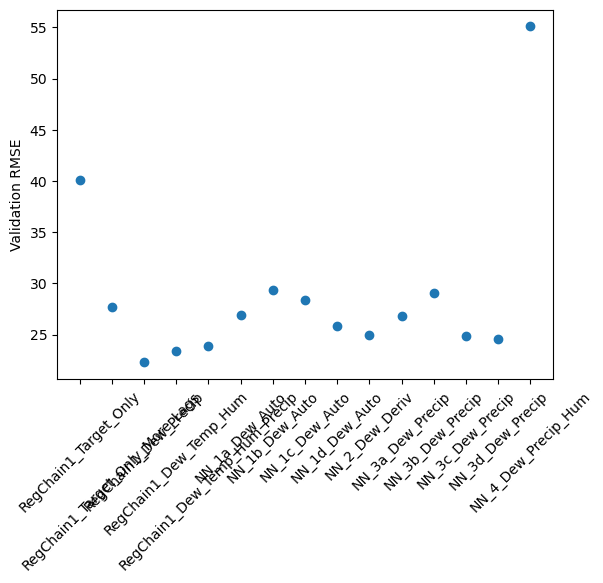

In [45]:
print(rmse_train_list)
print(rmse_valid_list)
print(rsquare_list)
fig, ax = plt.subplots()
plt.plot(model_labels,rmse_valid_list,marker='o',linestyle='')
plt.xticks(rotation = 45)
ax.set_ylabel('Validation RMSE')
plt.savefig('rmse_comparison.png')

# Plot Results

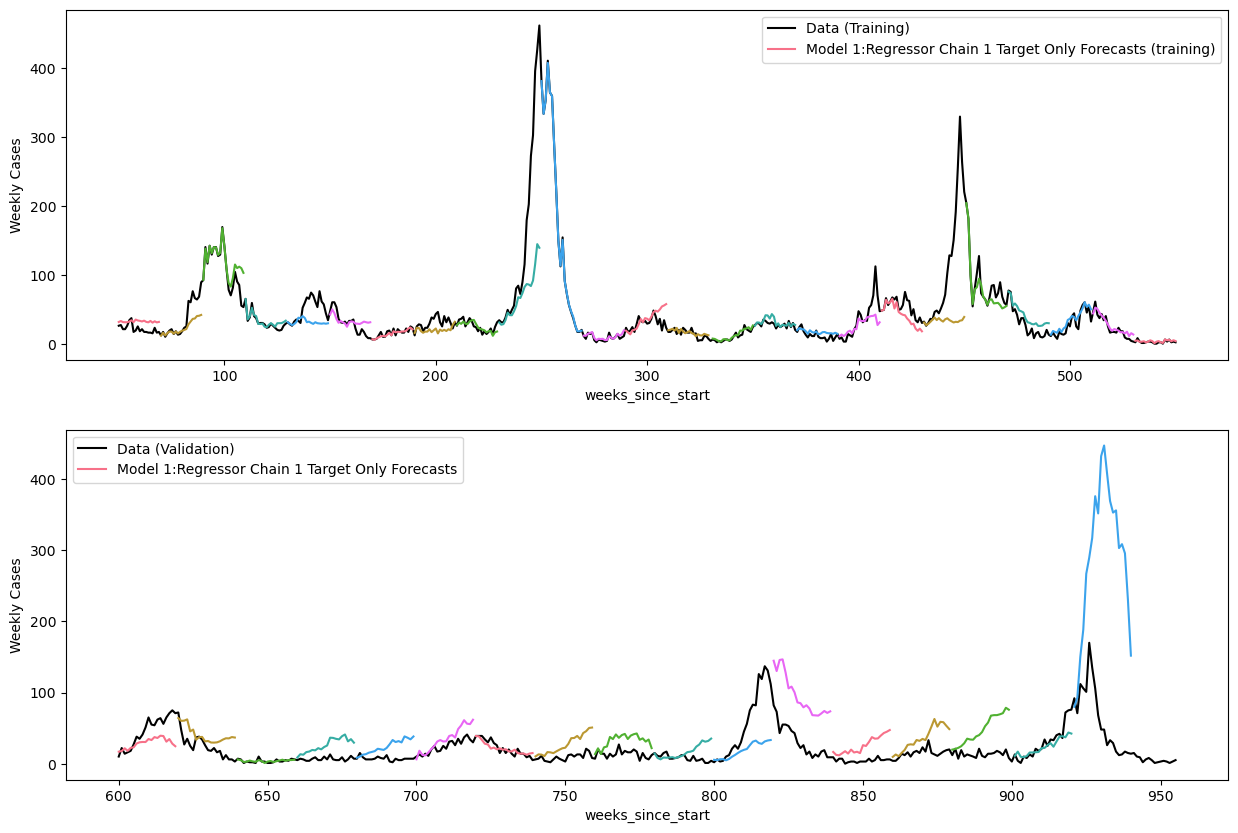

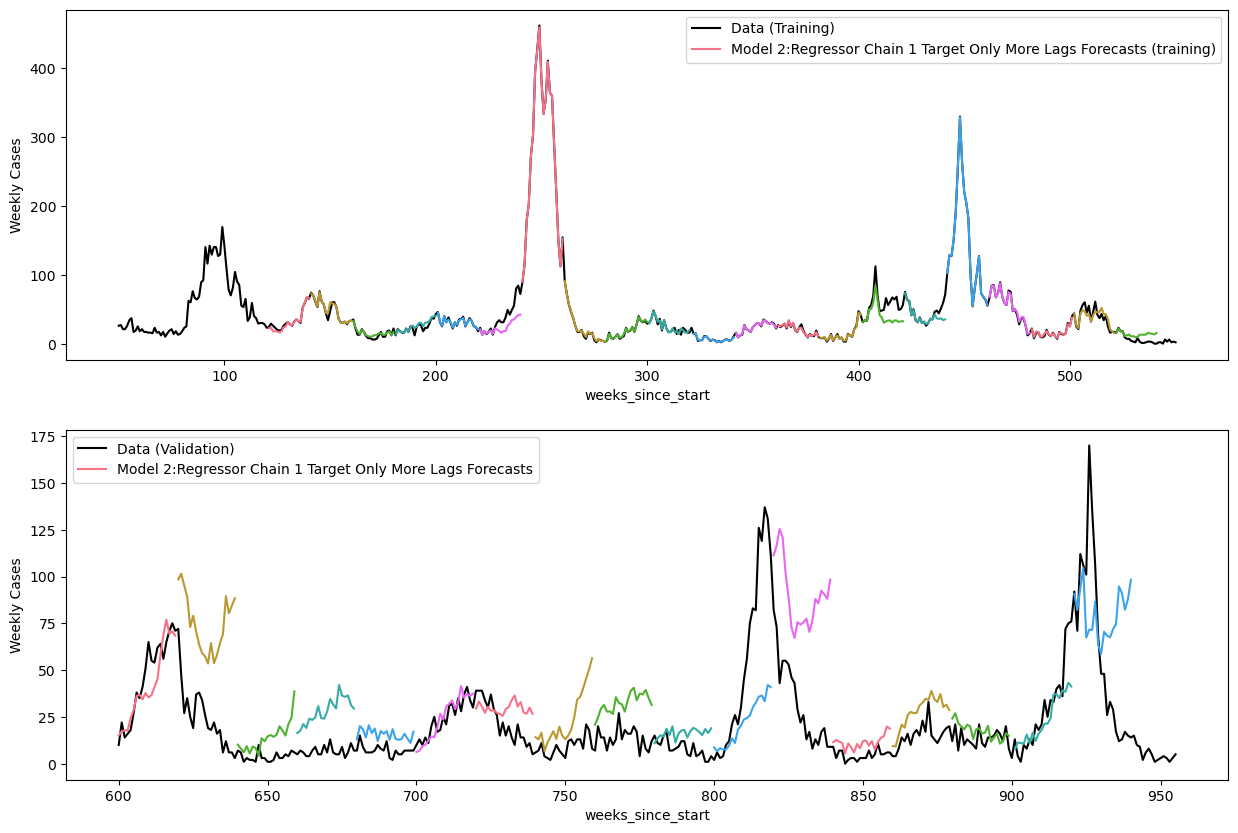

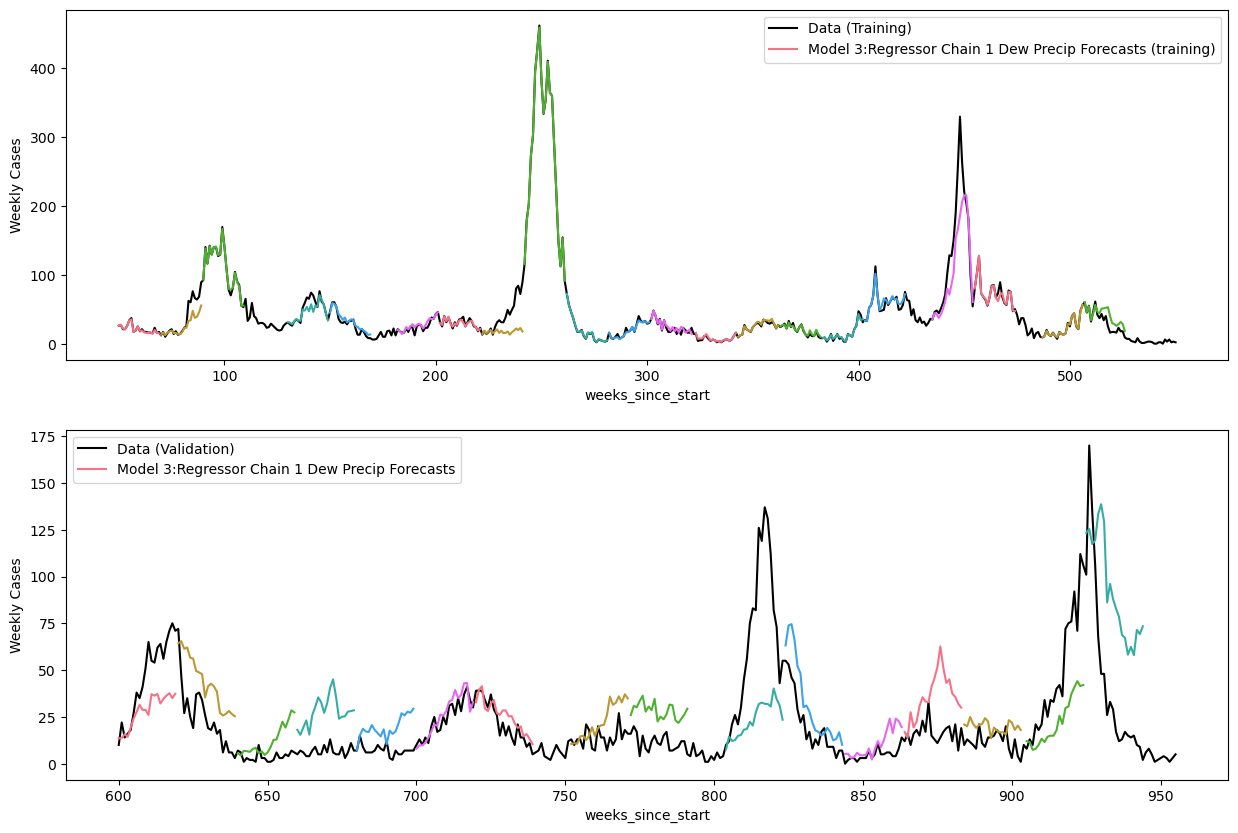

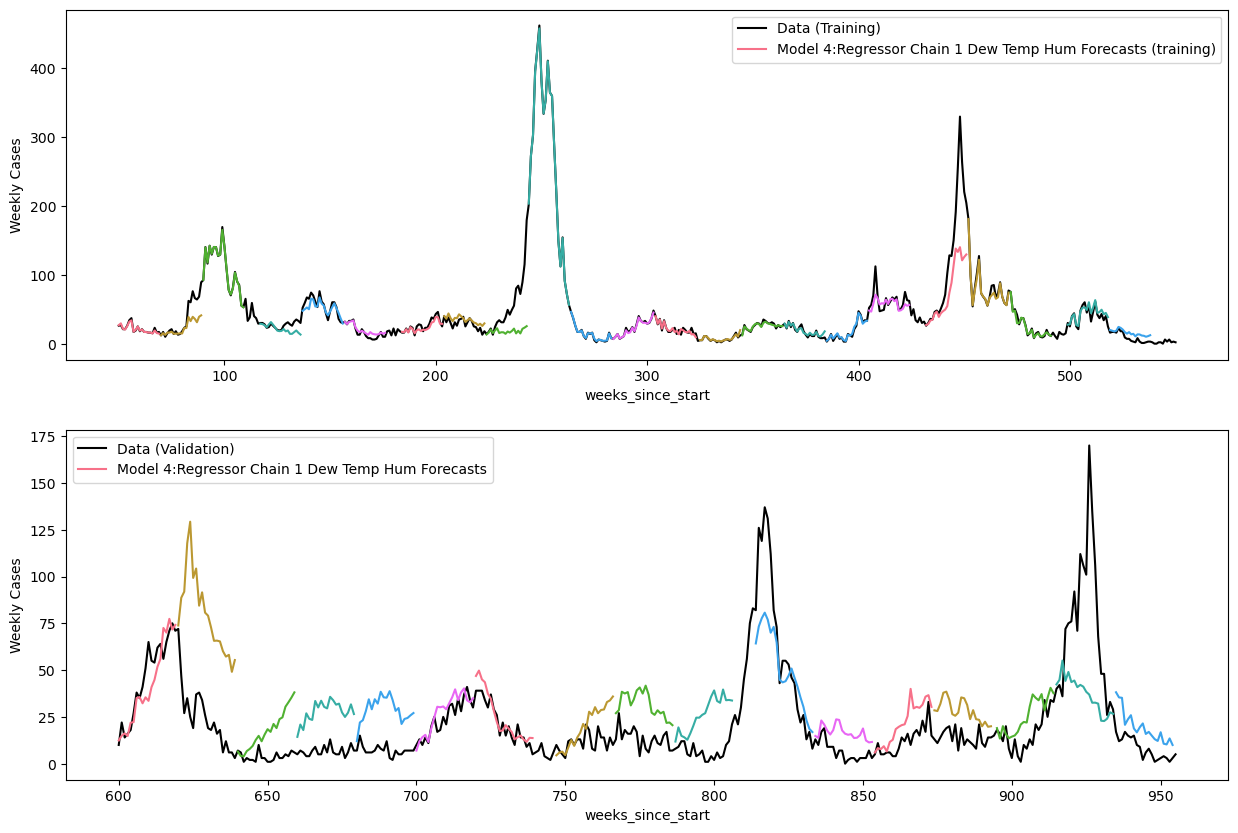

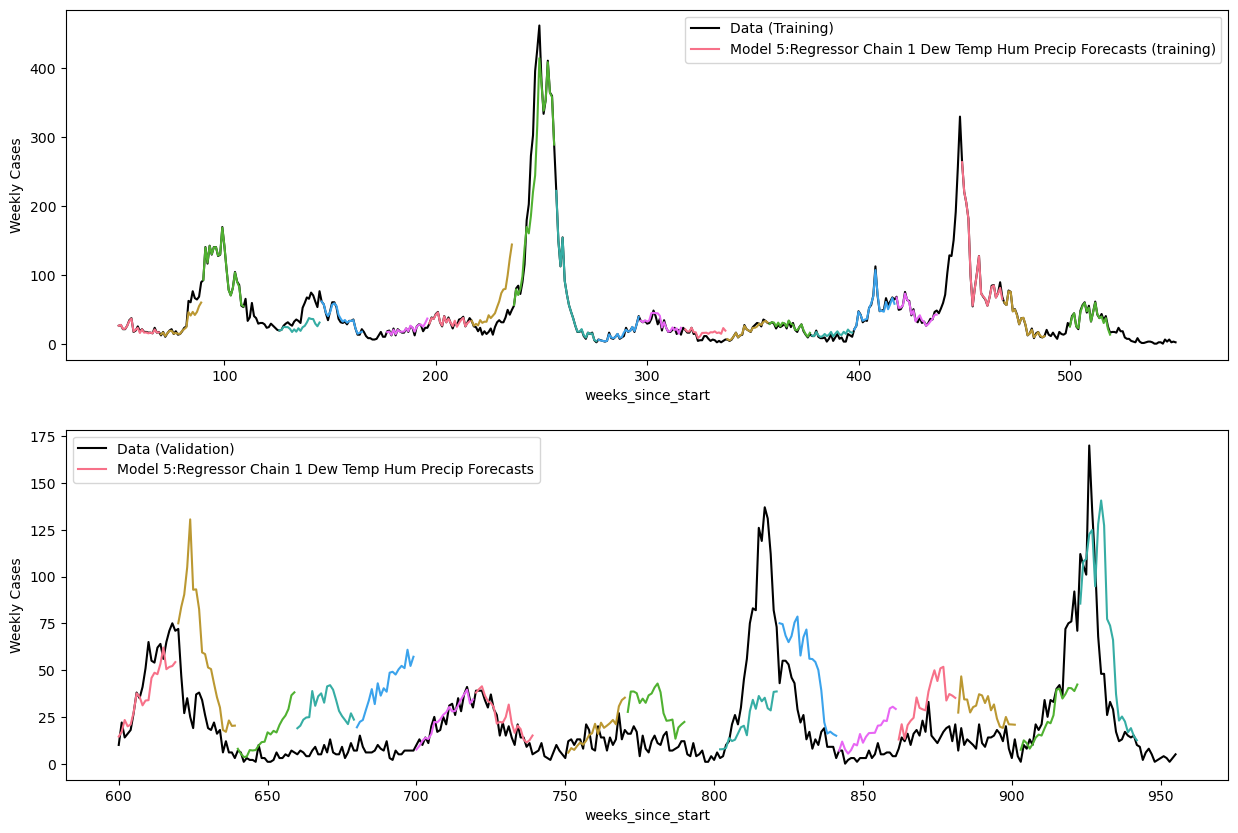

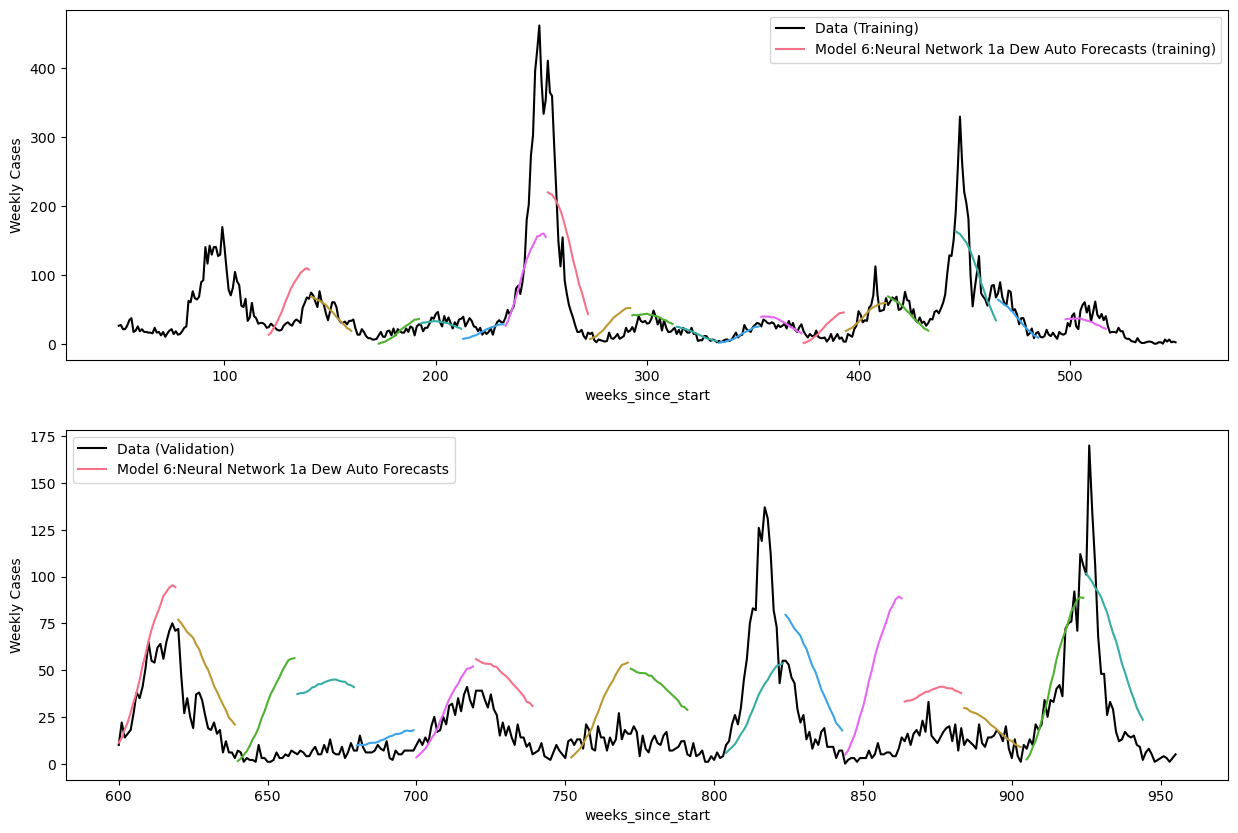

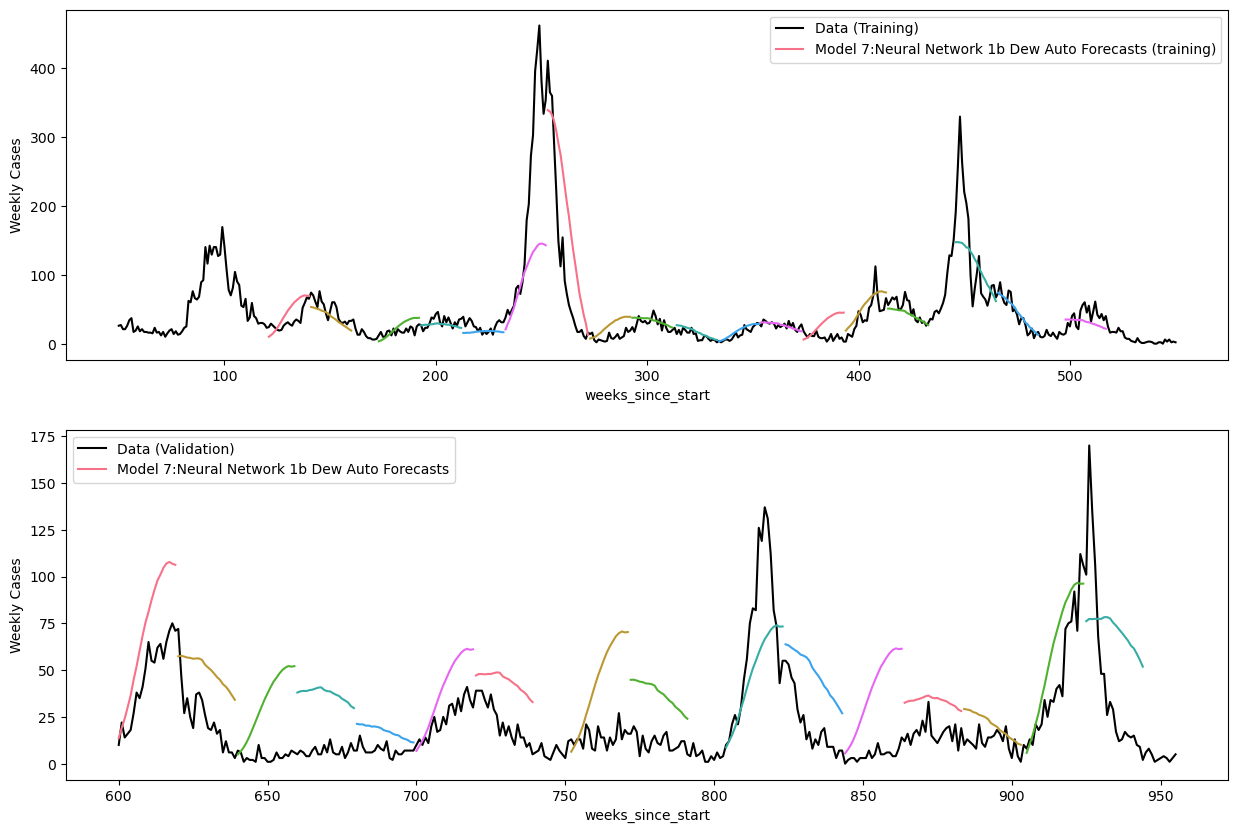

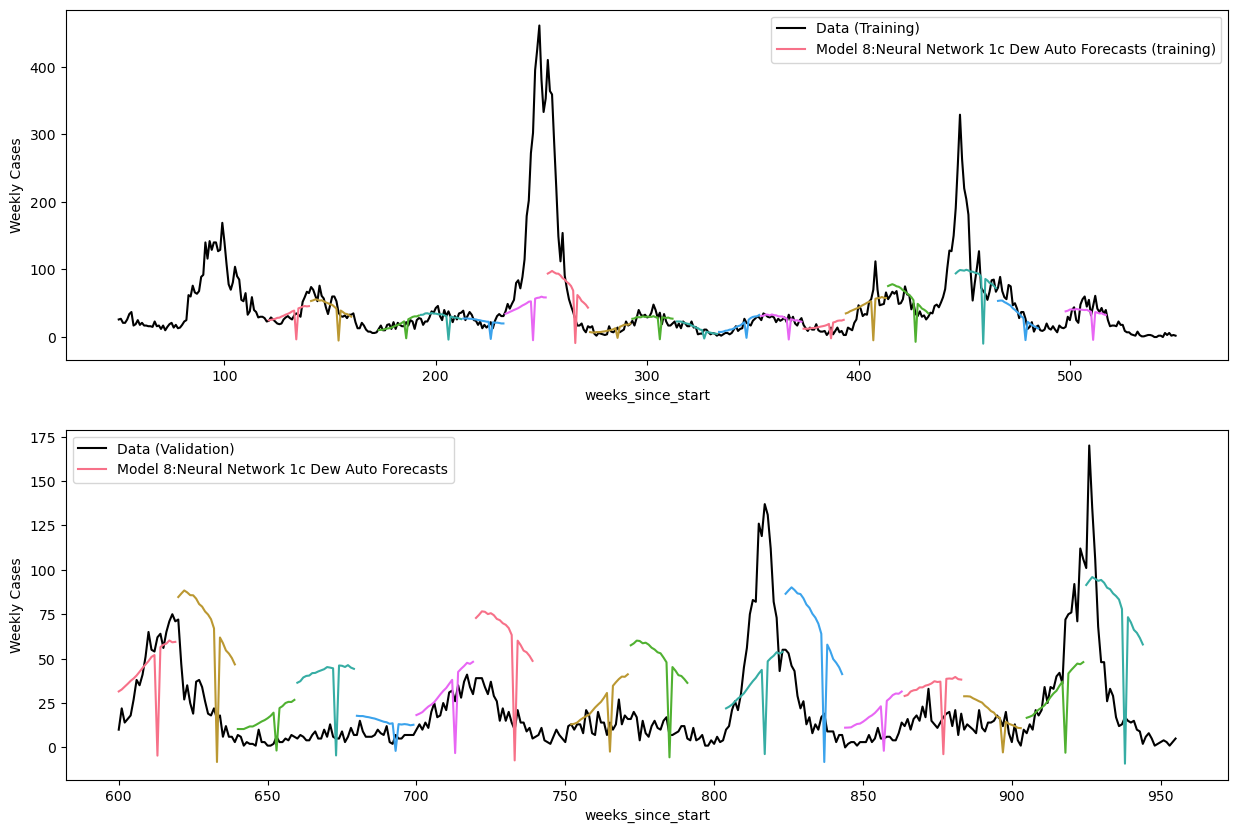

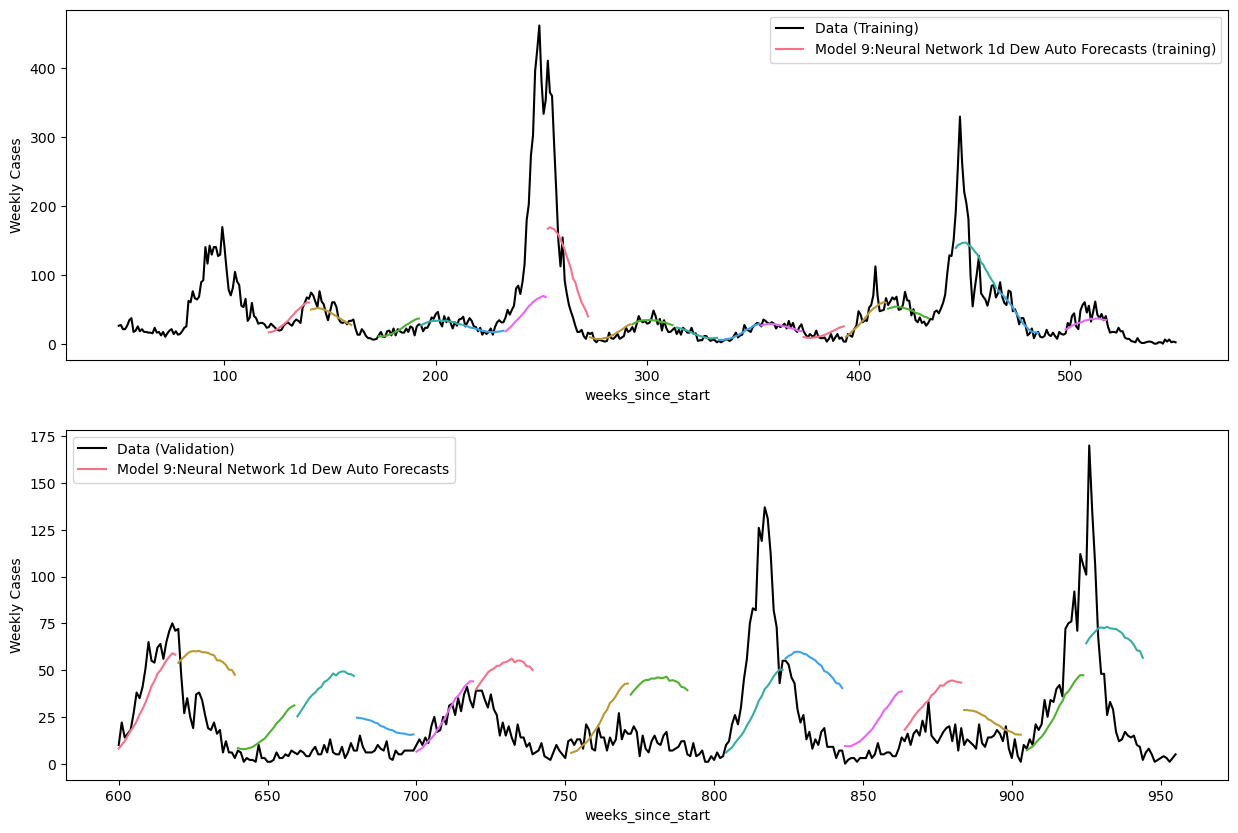

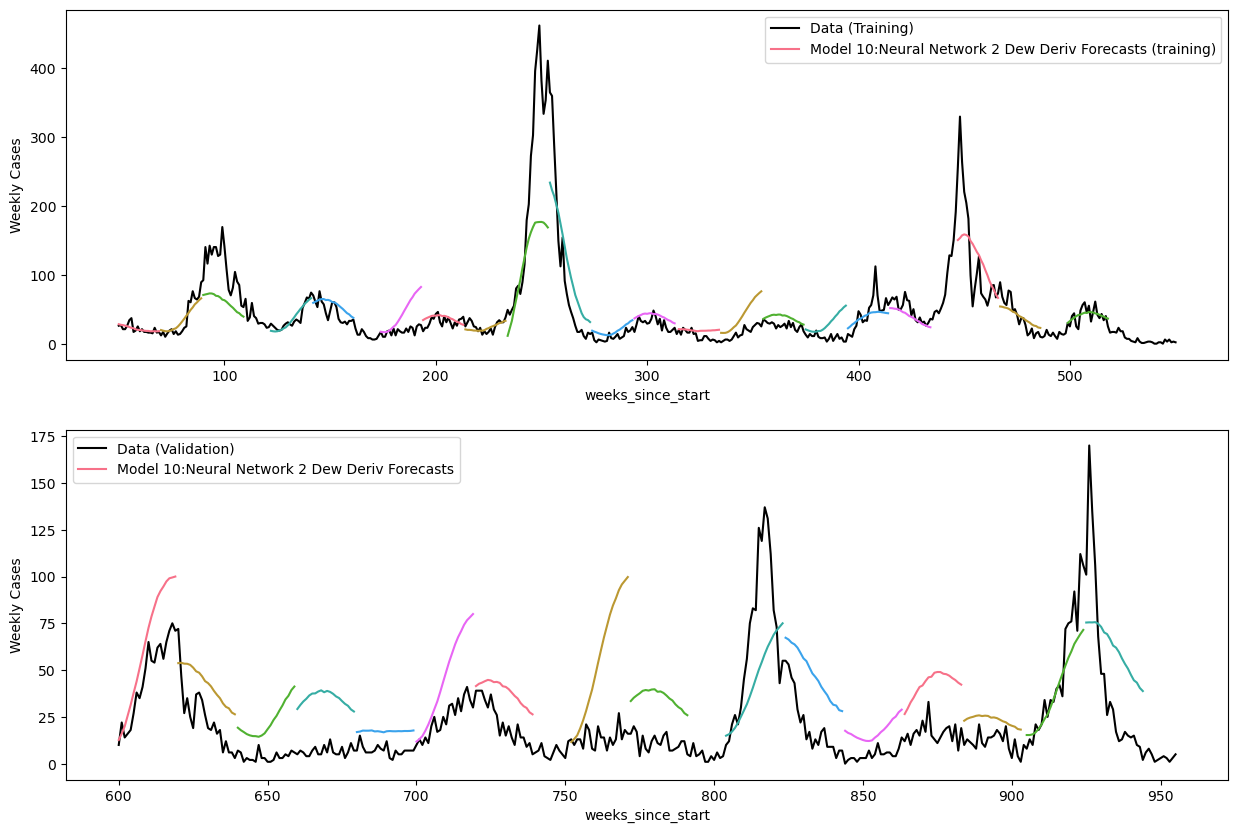

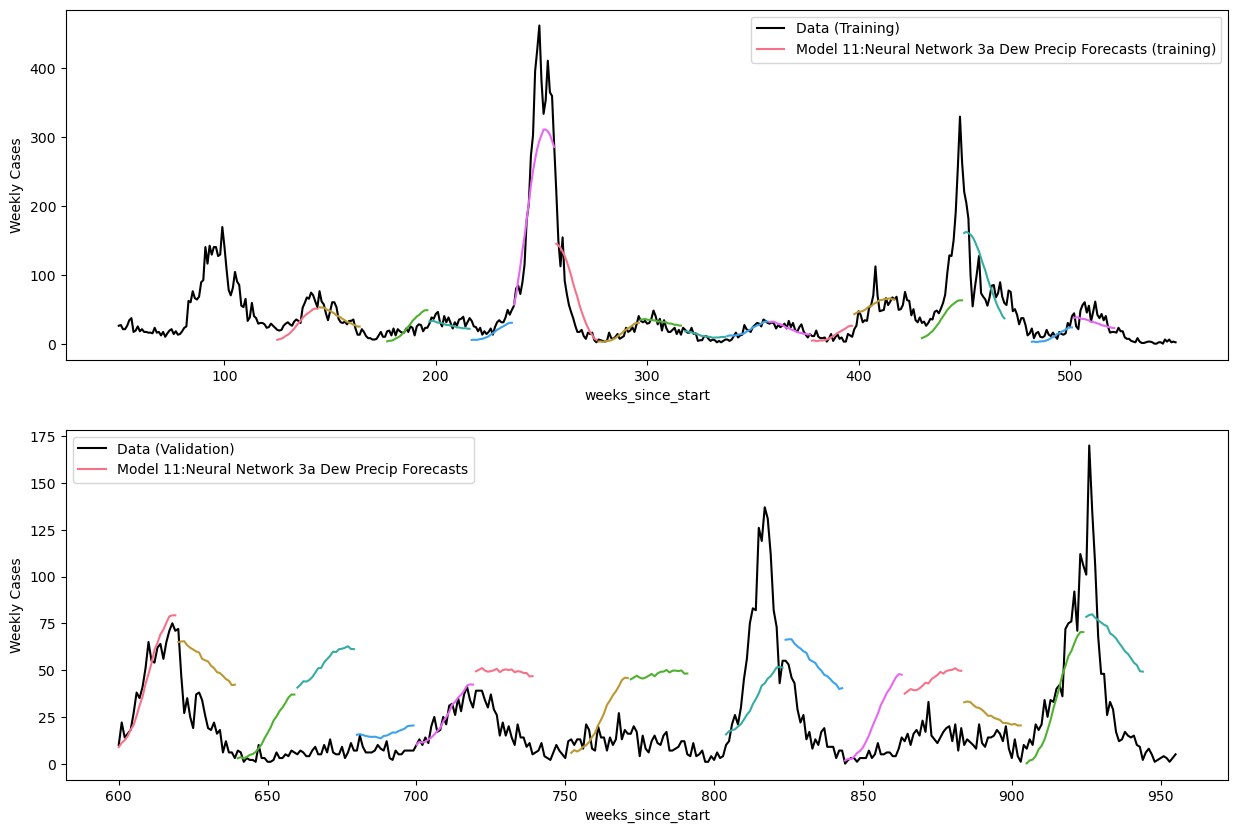

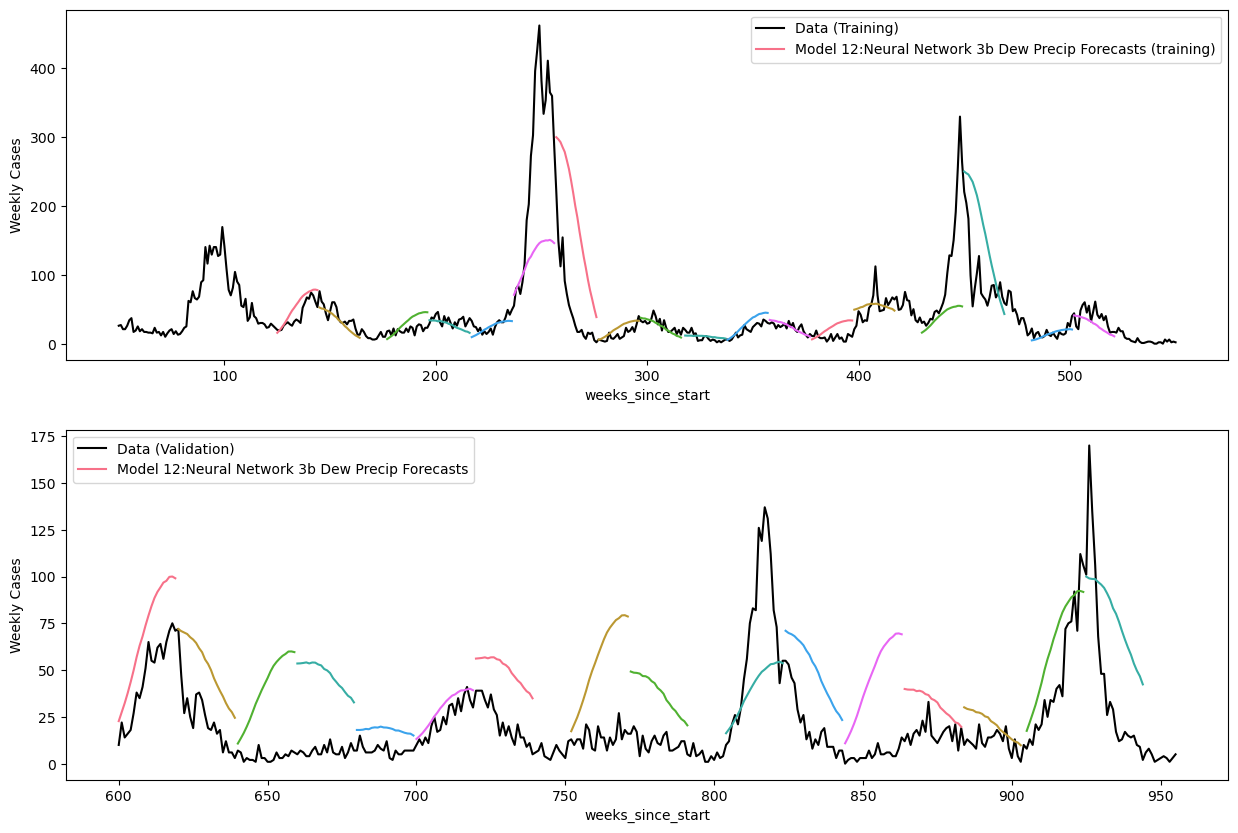

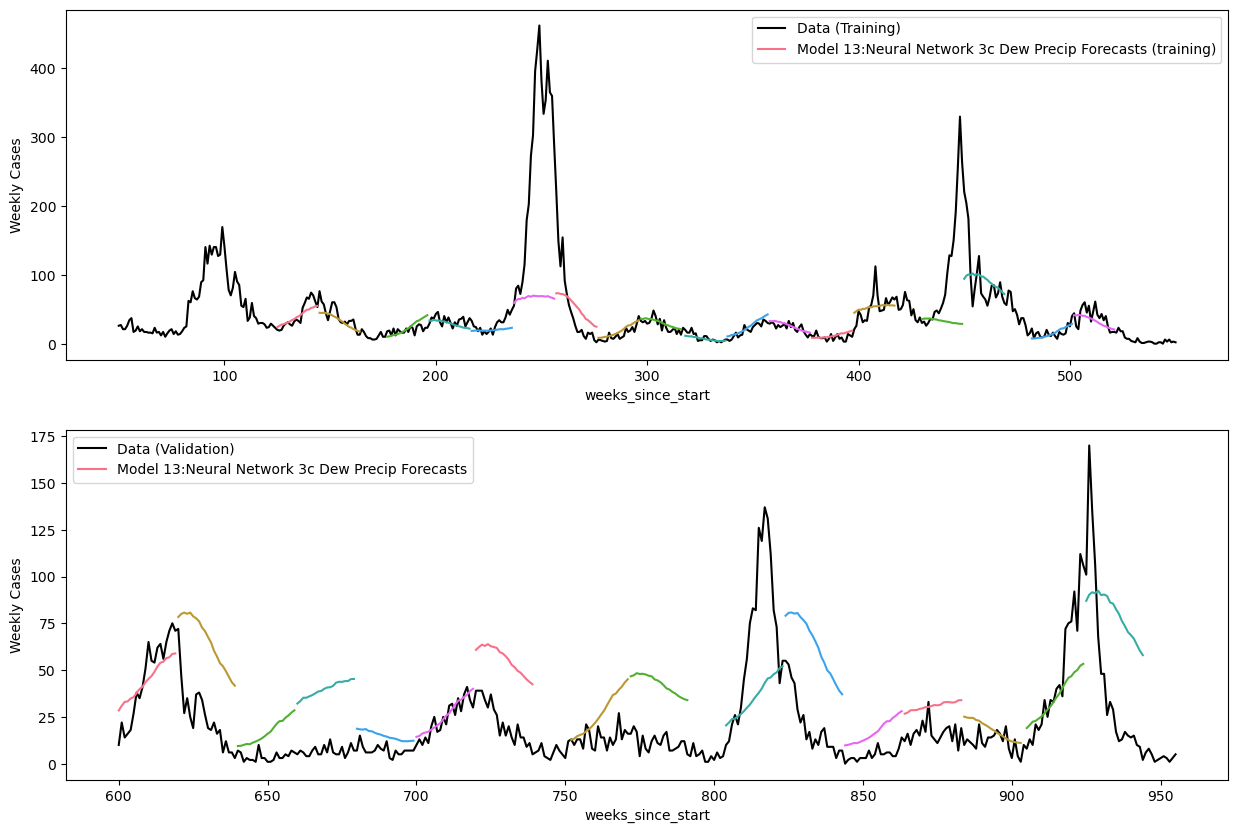

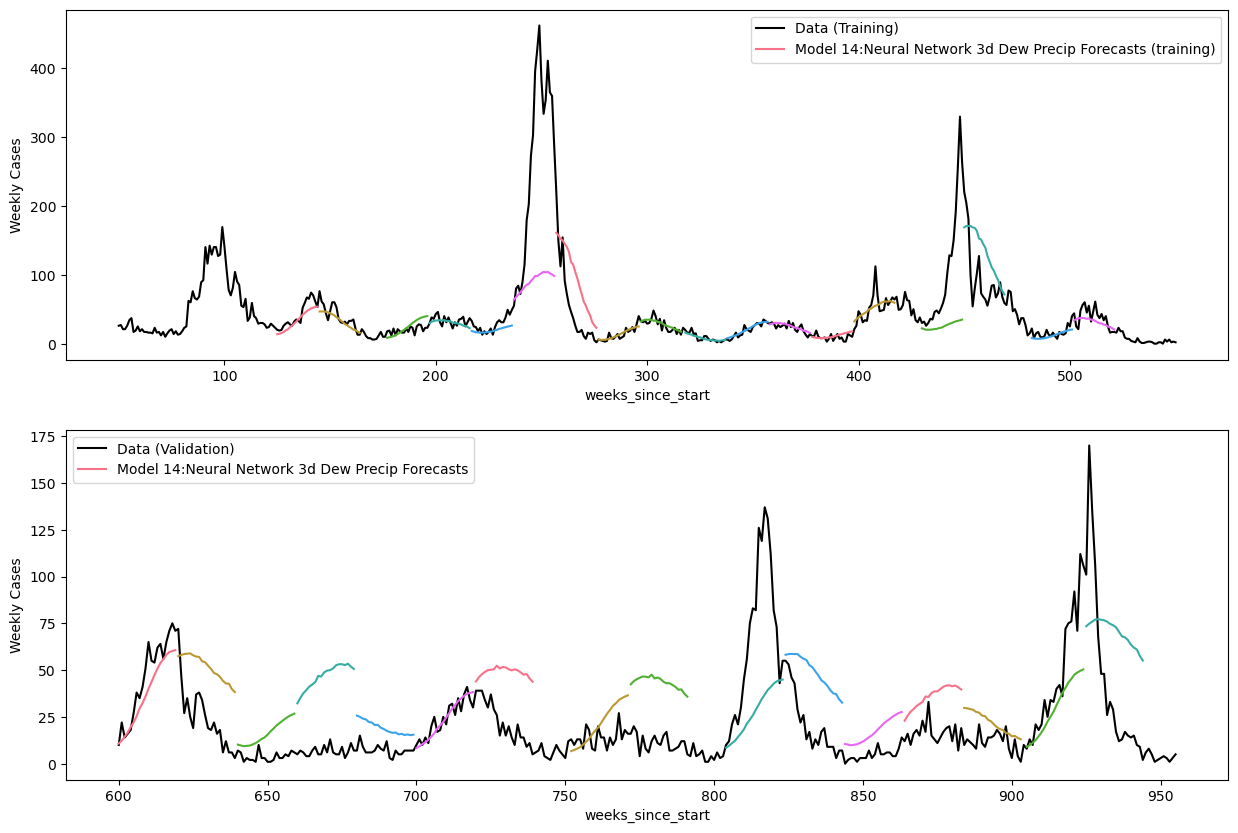

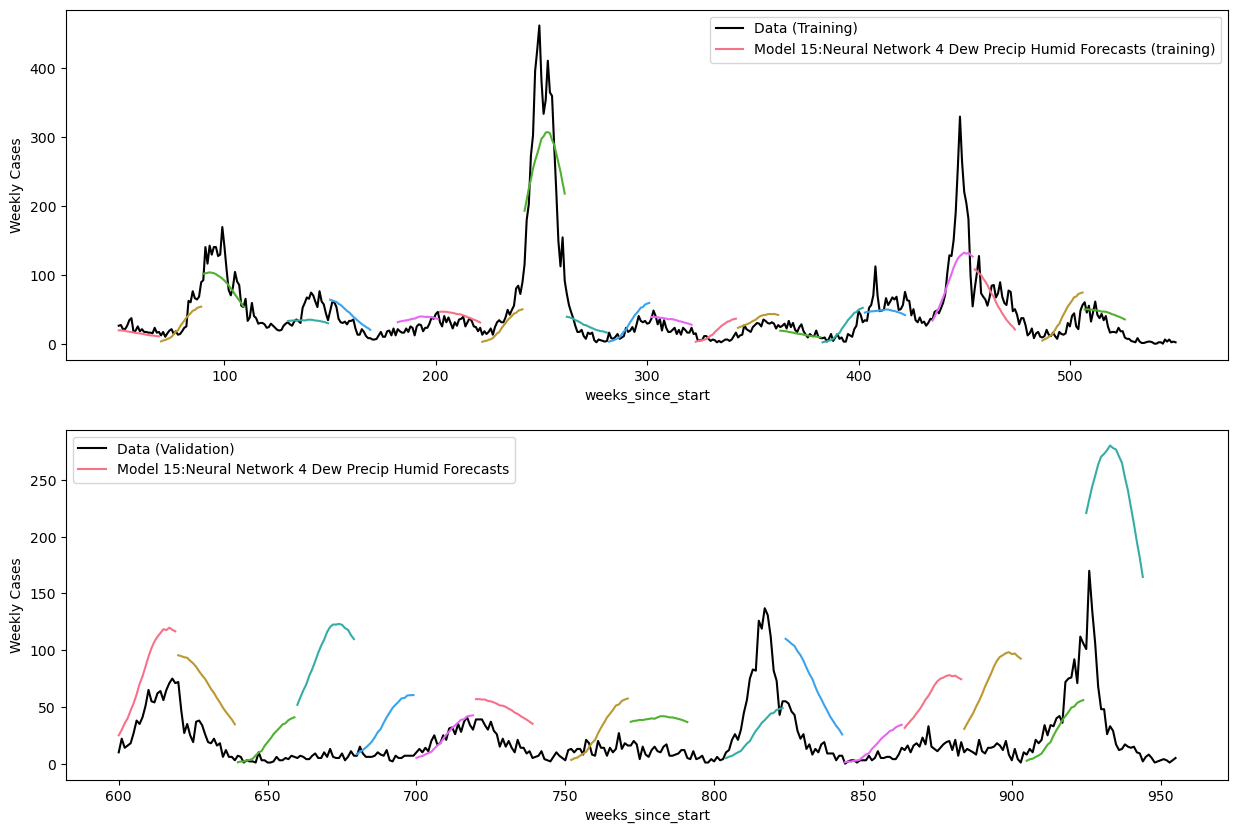

In [46]:

for i in range(len(model_list)):
    y_pred_train = y_pred_train_list[i]
    y_pred_valid = y_pred_valid_list[i]

    model_name  = model_labels[i]
    model_title = model_titles[i]

    EVERY = 20

    START=50
    END=550
    
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))
    line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

    x=plot_multistep(y_pred_train.loc[START:END],ax=ax1,every=EVERY)
    ax1.set_ylabel('Weekly Cases')
    ax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])

    EVERY = 20

    START=600
    END=1100

    #fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

    x=plot_multistep(y_pred_valid.loc[START:END],ax=ax2,every=EVERY)

    ax2.set_ylabel('Weekly Cases')
    ax2.legend(['Data (Validation)',f'Model {i+1}:{model_title} Forecasts'])

    plt.savefig(f'model_{i+1}_{model_name}.png')

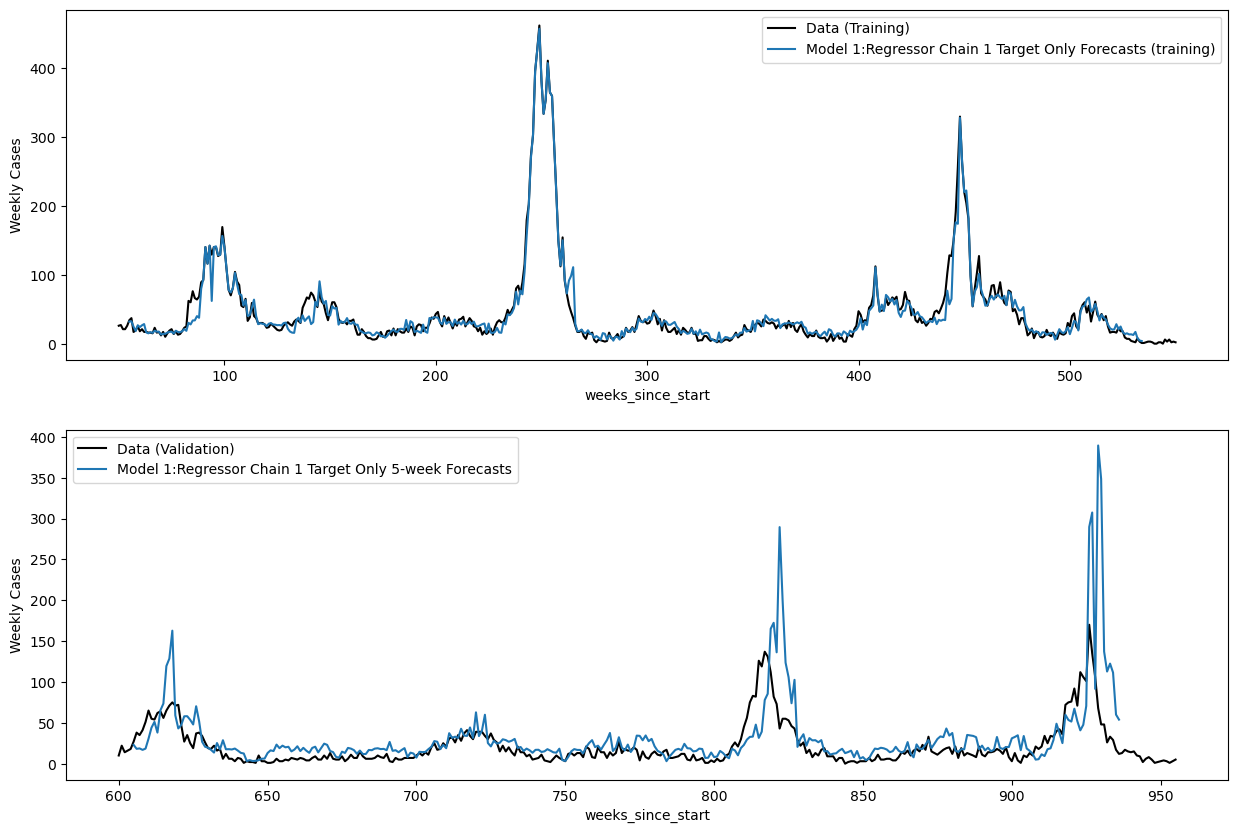

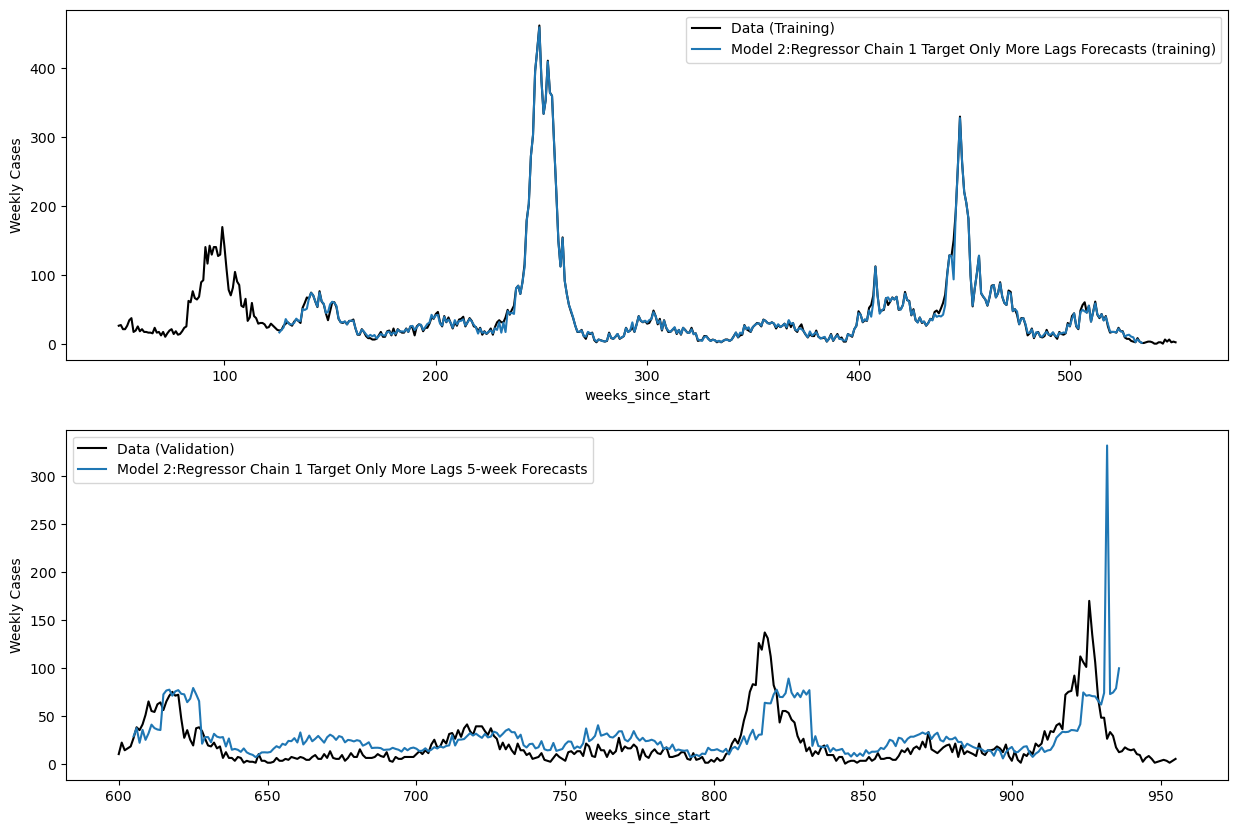

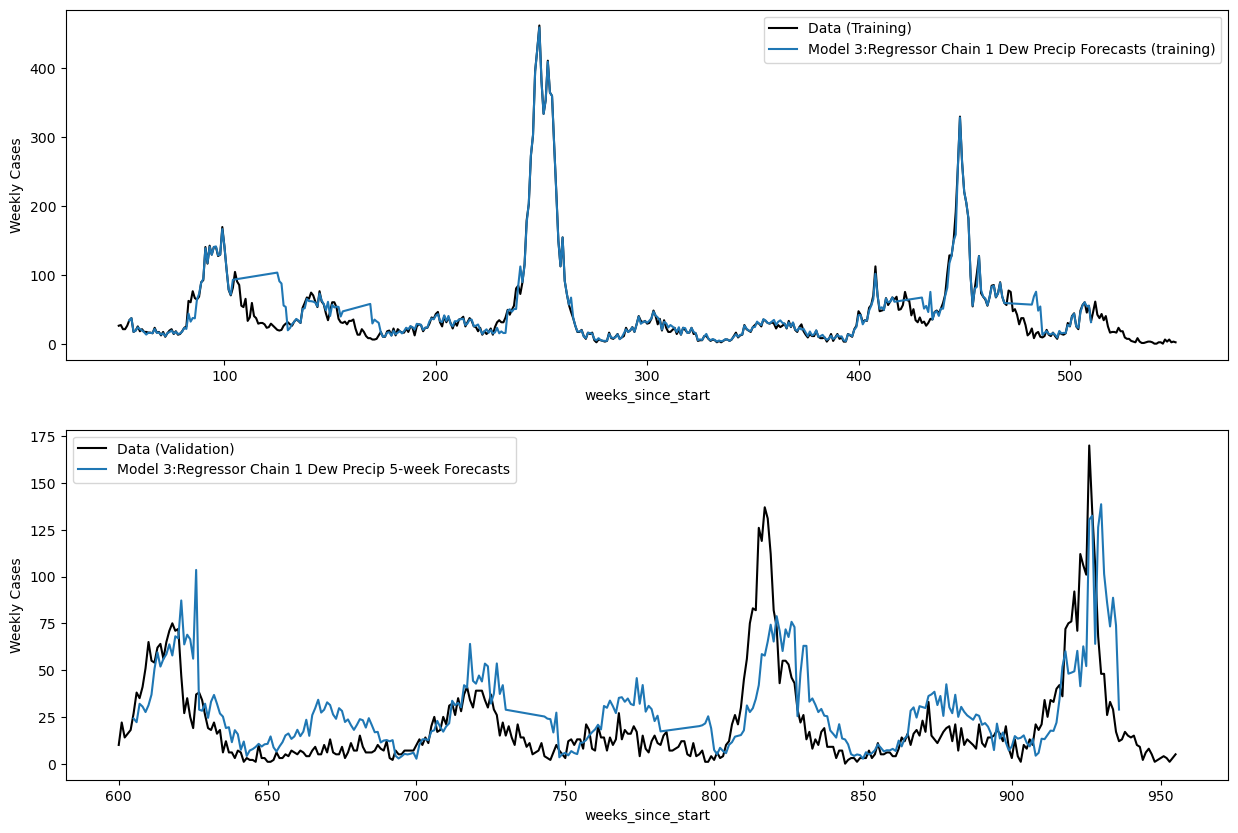

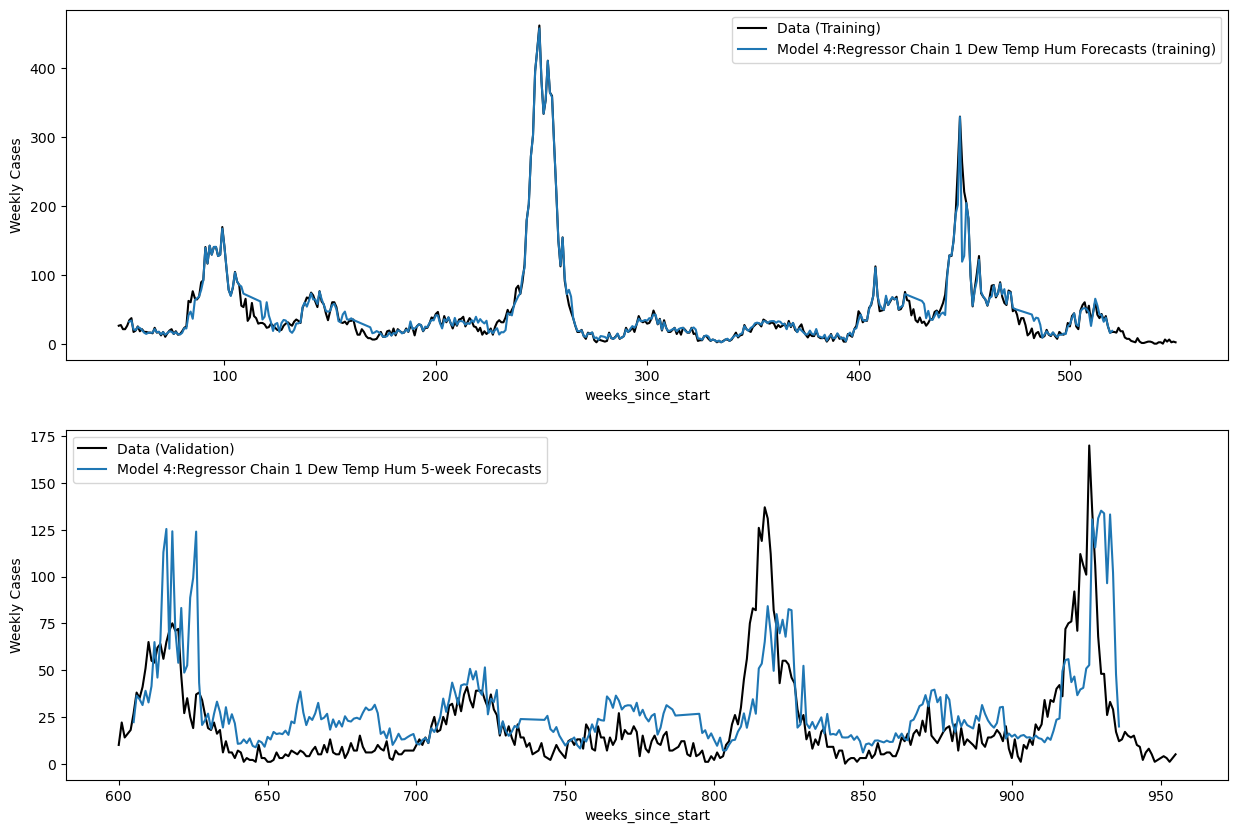

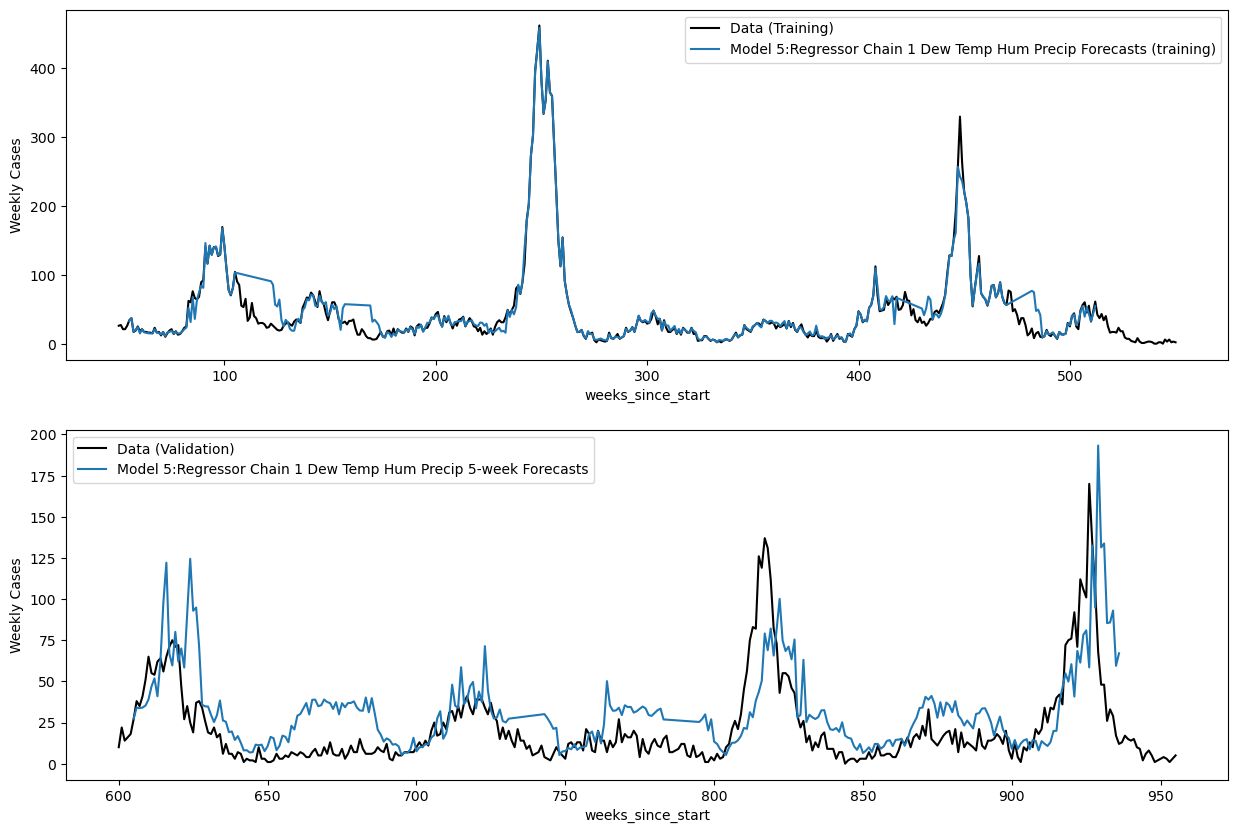

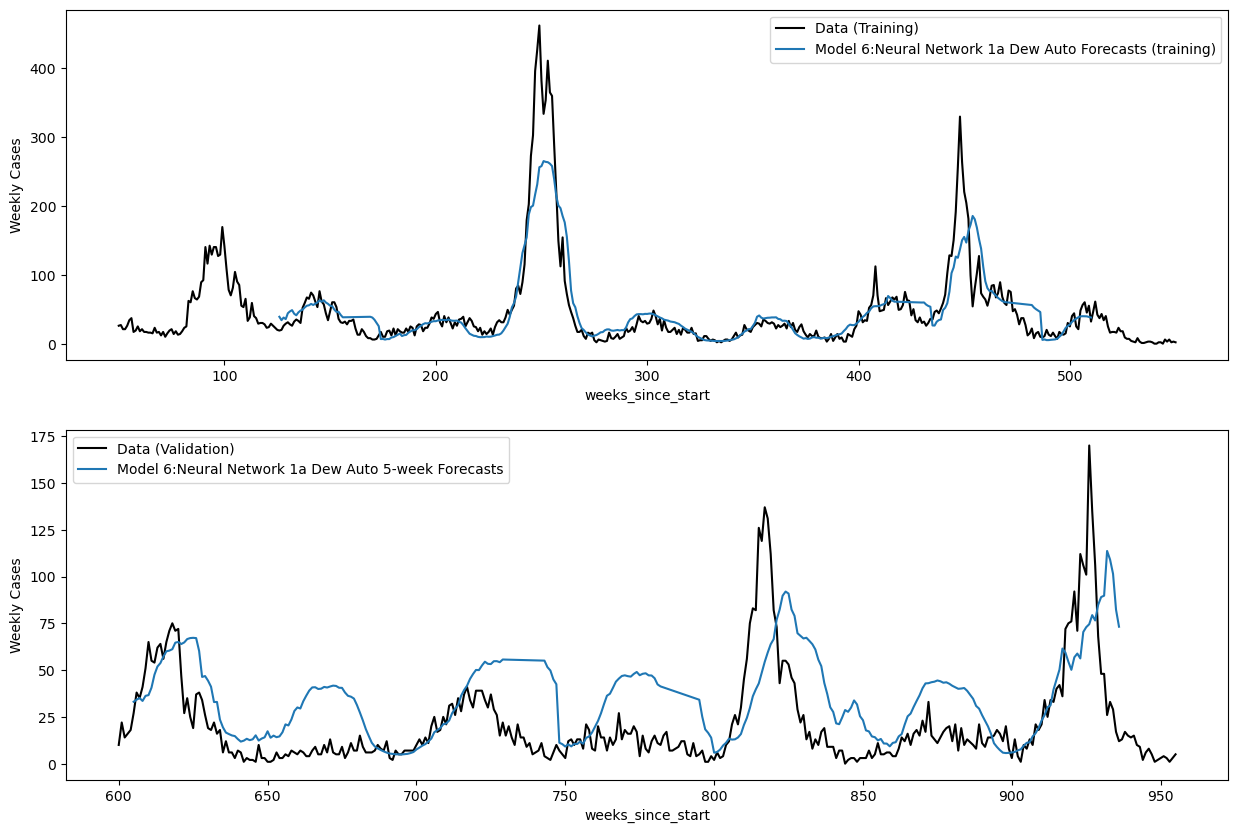

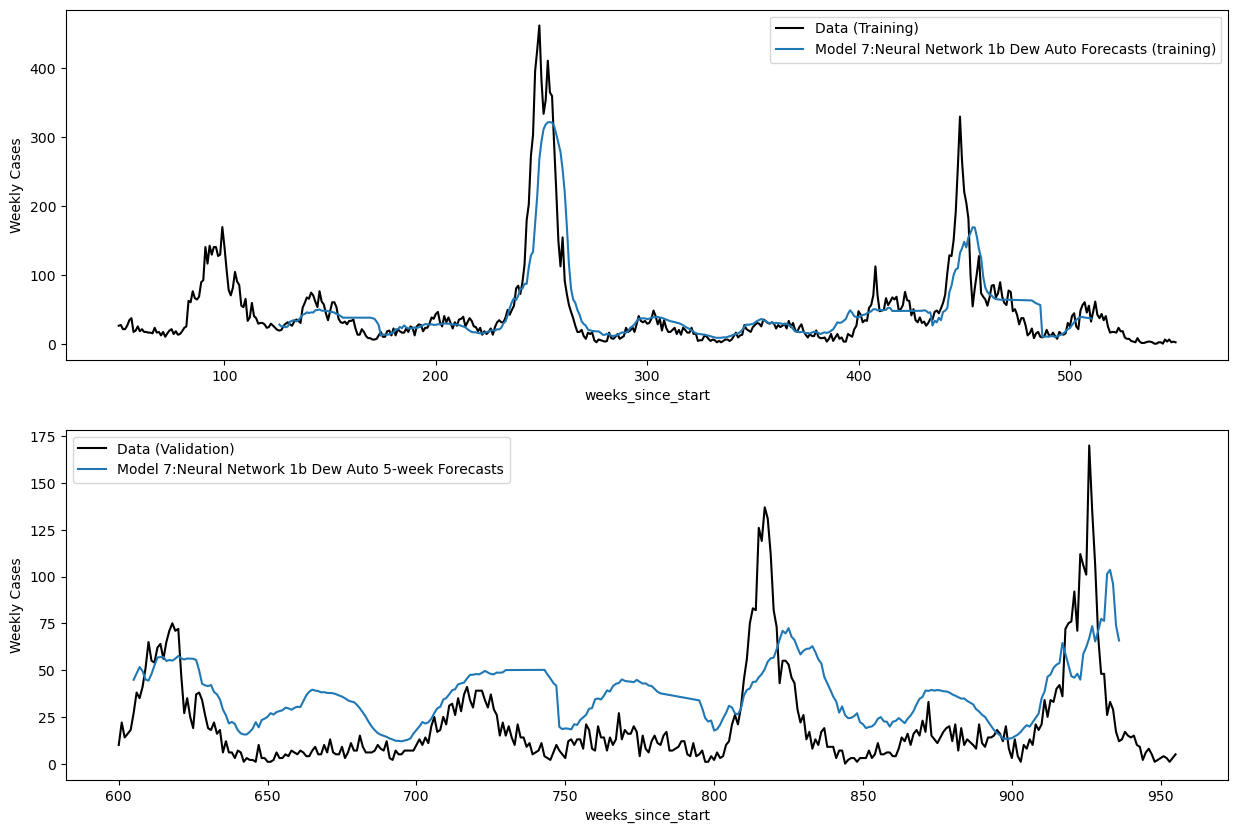

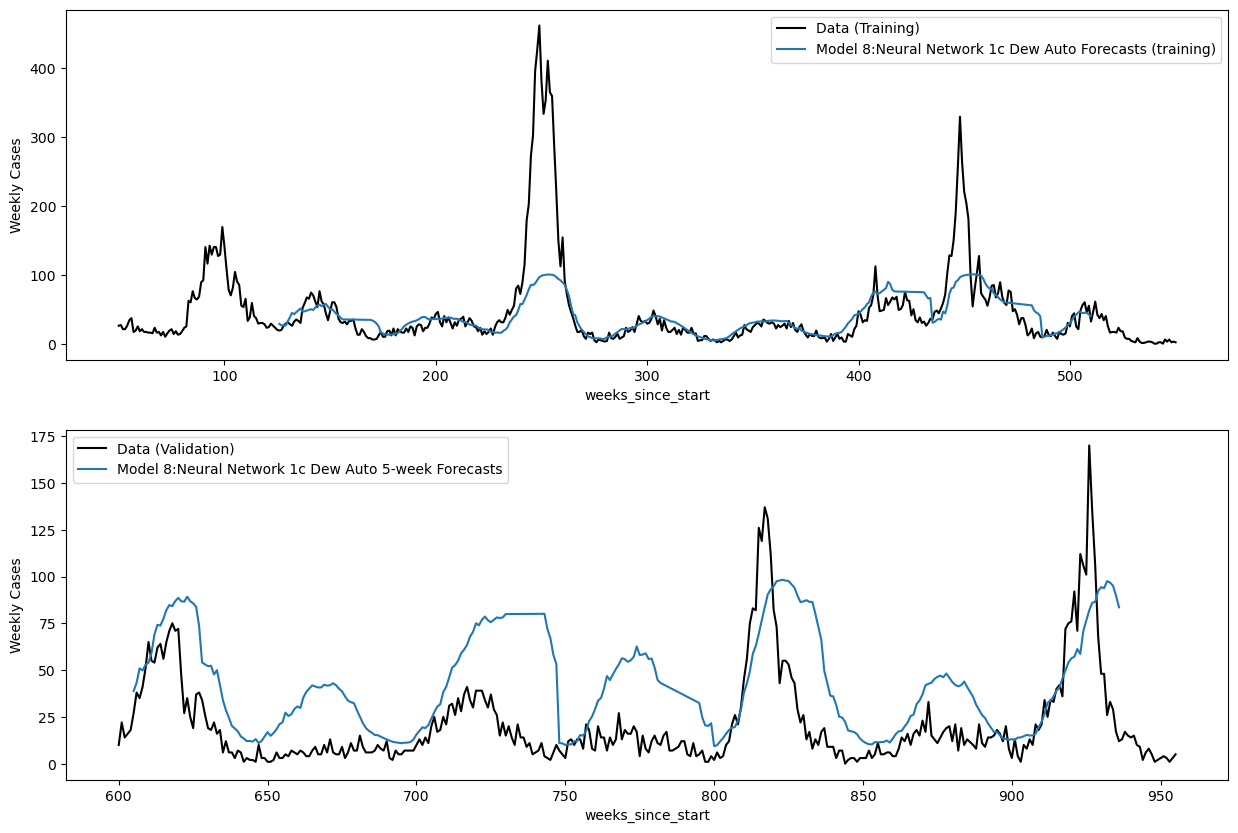

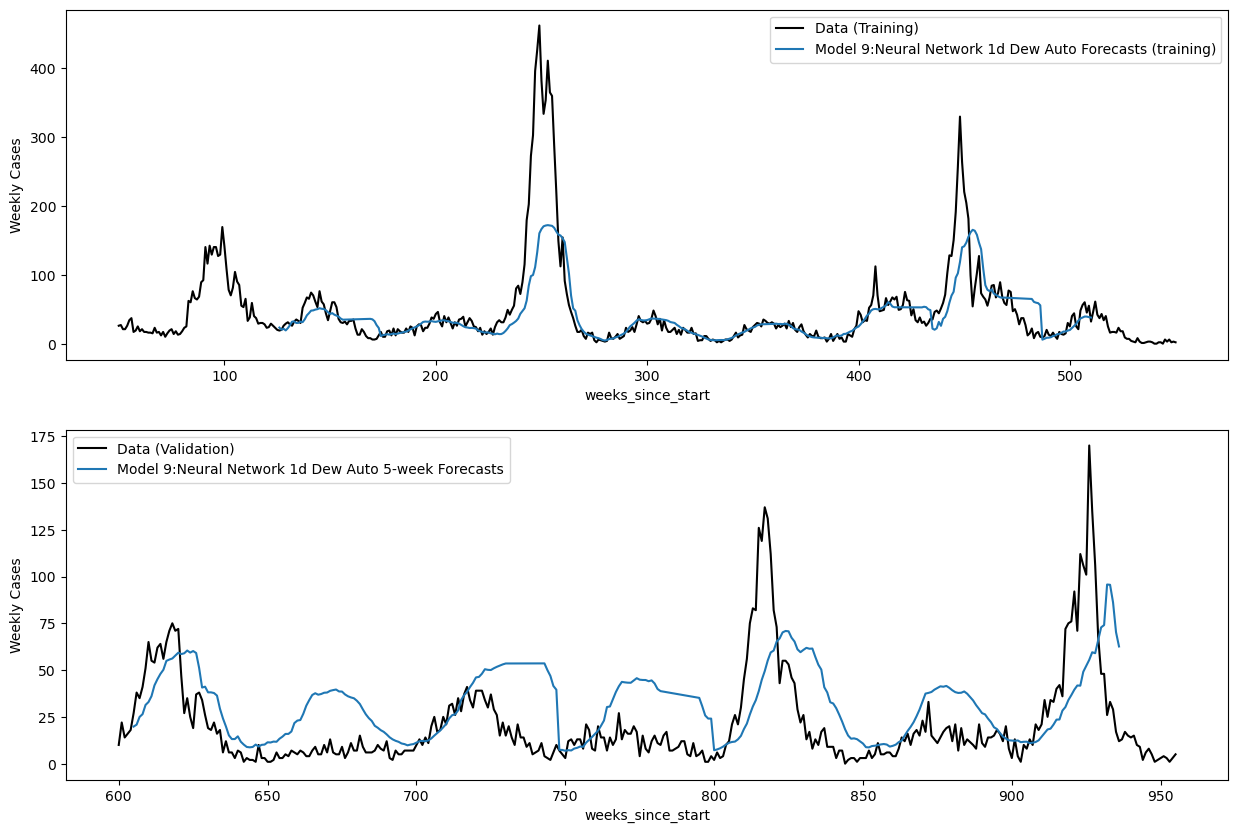

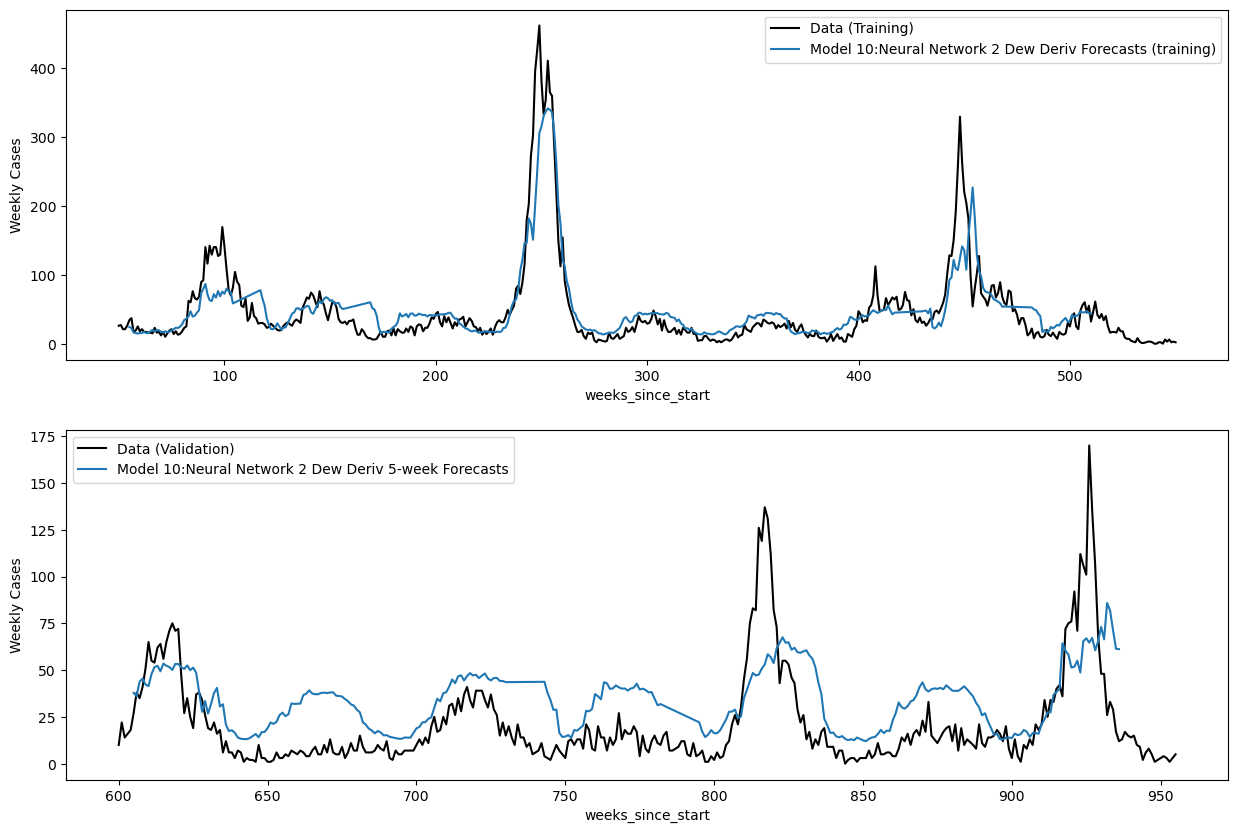

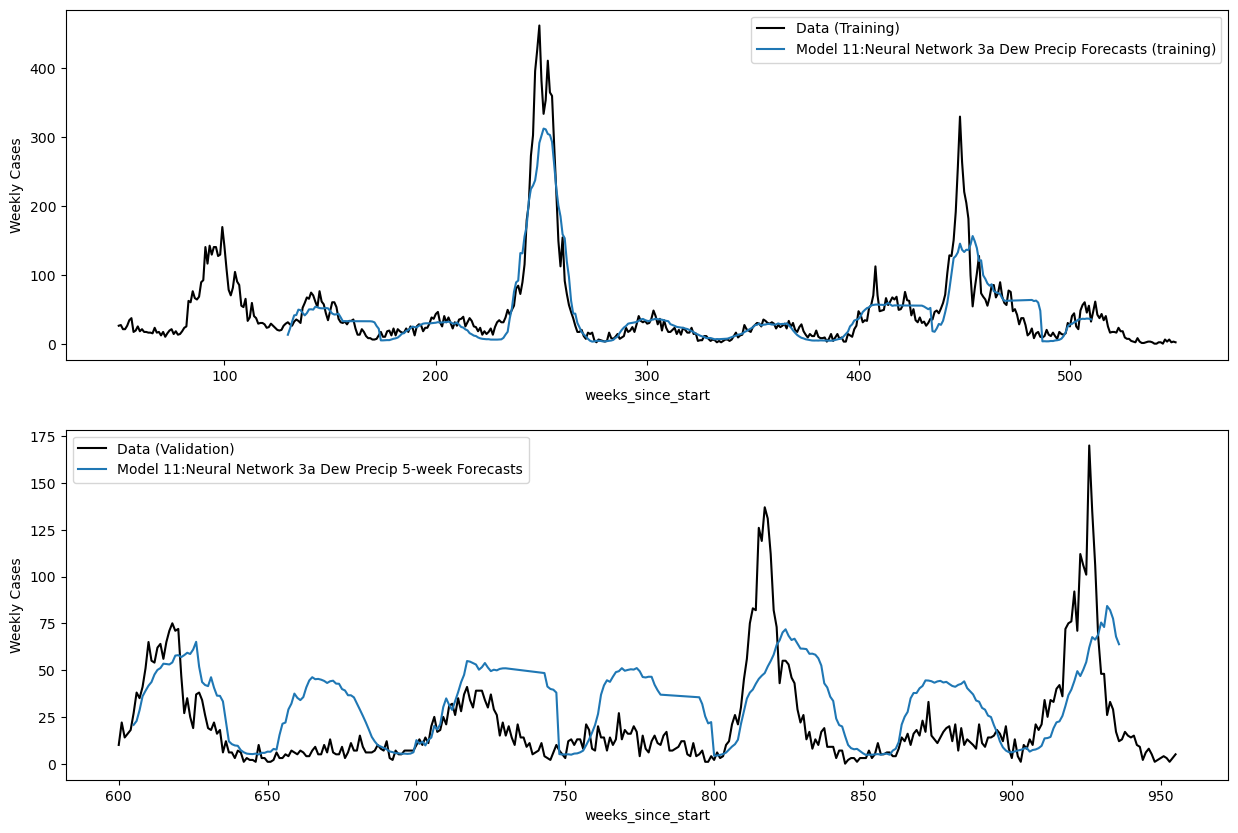

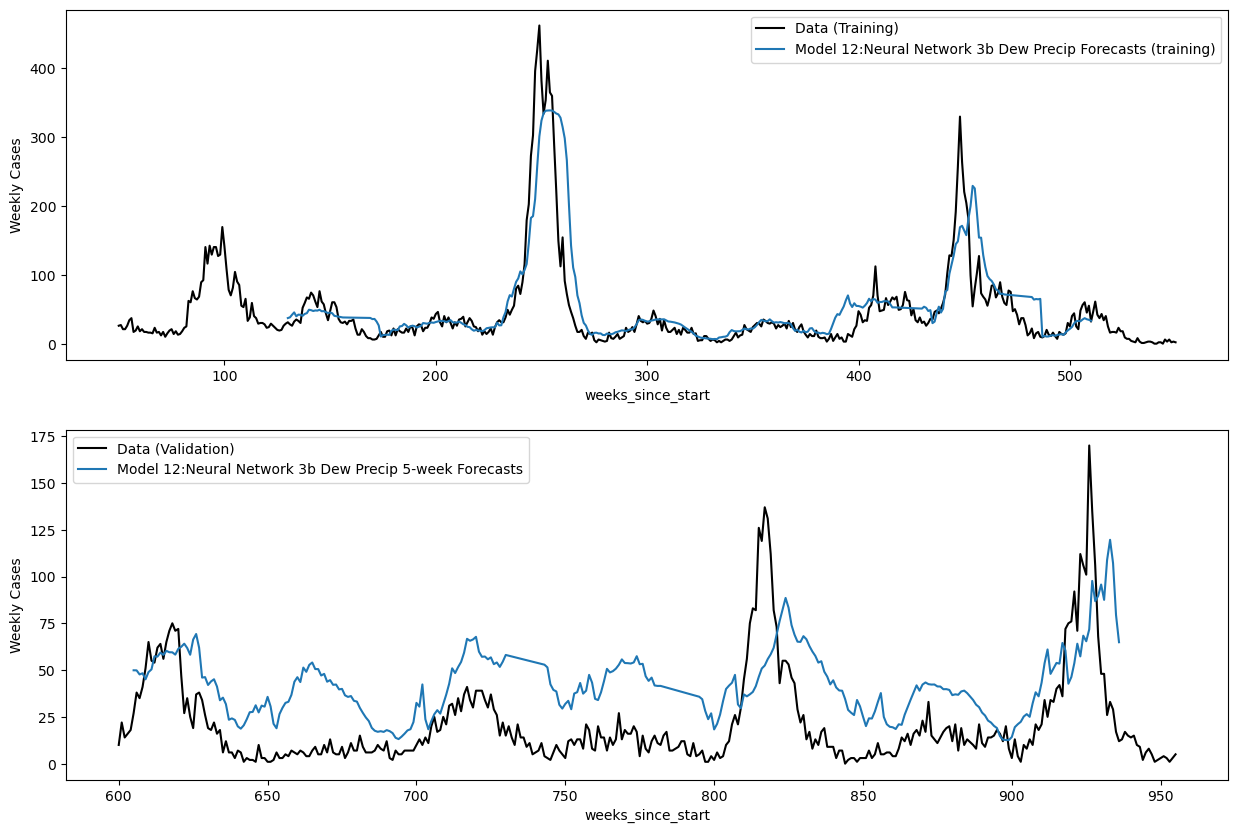

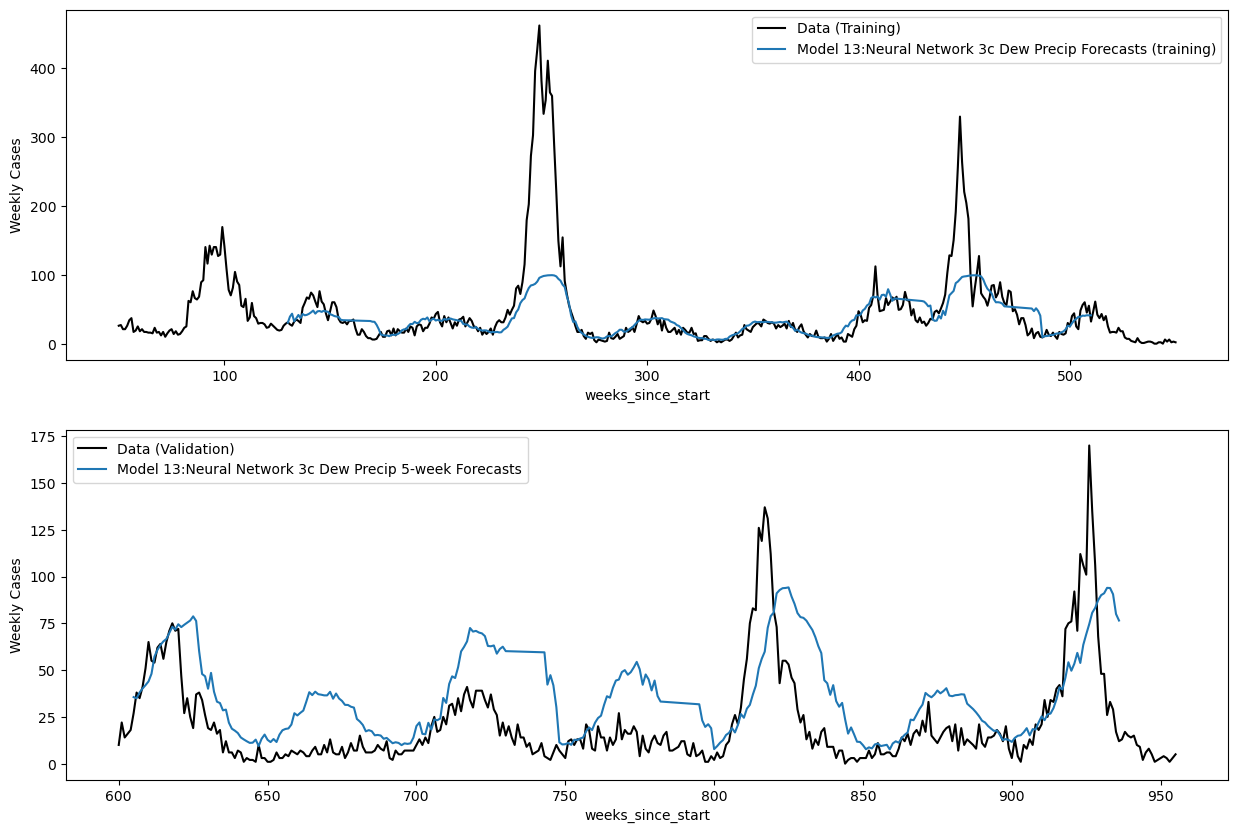

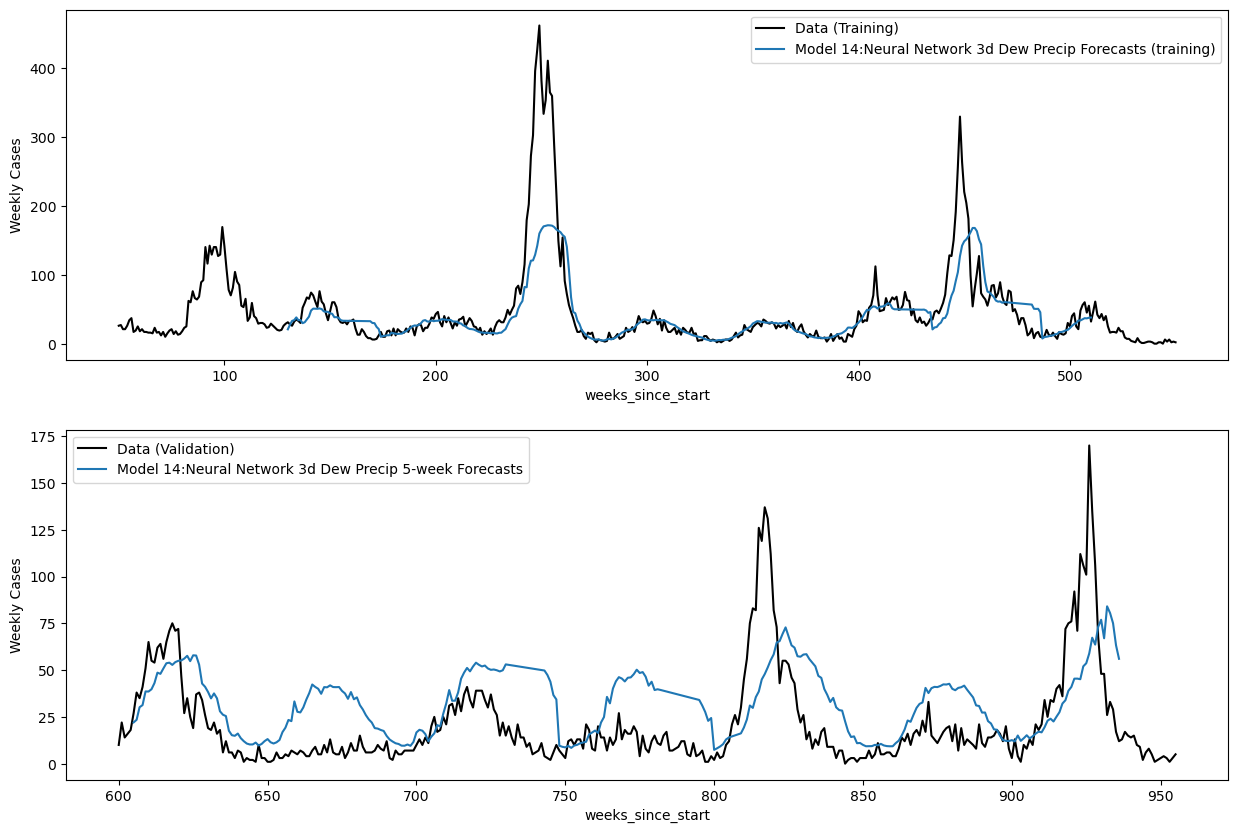

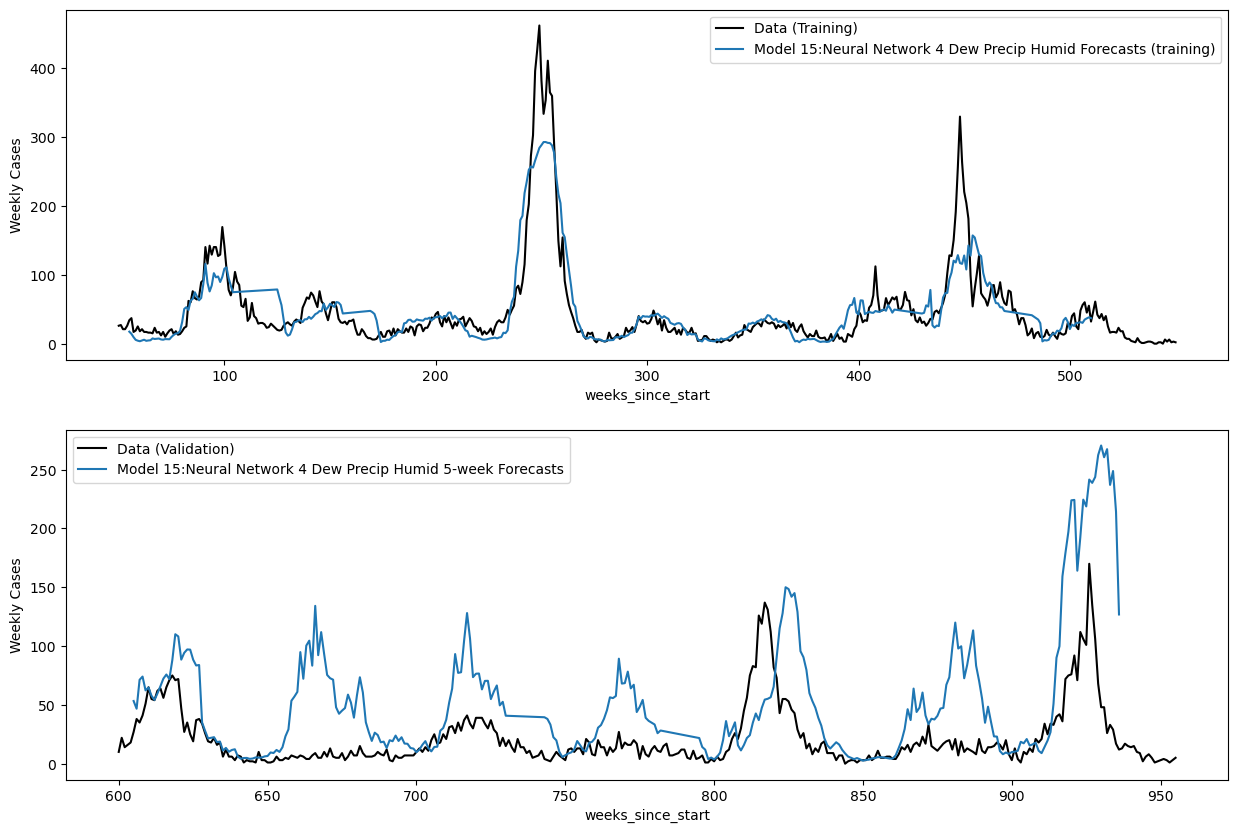

In [47]:
# New: try to plot the forecast for n weeks into the future

nth_step=5

for i in range(len(model_list)):
    y_pred_train = y_pred_train_list[i]
    y_pred_valid = y_pred_valid_list[i]

    model_name  = model_labels[i]
    model_title = model_titles[i]

    EVERY = 20

    START=50
    END=550
    
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))
    line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

    #x=plot_multistep(y_pred_train.loc[START:END],ax=ax1,every=EVERY)
    x = plot_nth_step(y_pred_train.loc[START:END],nstep=nth_step,ax=ax1)
    ax1.set_ylabel('Weekly Cases')
    ax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])

    EVERY = 20

    START=600
    END=1100

    #fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

    x = plot_nth_step(y_pred_valid.loc[START:END],nstep=nth_step,ax=ax2)
    # def plot_nth_step(y, nstep=1,ax=None,palette_kwargs=None):
    #x=plot_multistep(y_pred_valid.loc[START:END],ax=ax2,every=EVERY)

    ax2.set_ylabel('Weekly Cases')
    ax2.legend(['Data (Validation)',f'Model {i+1}:{model_title} {nth_step}-week Forecasts'])

    plt.savefig(f'nth_step_model_{i+1}_{model_name}.png')

# Thoughts

* These models don't explicitly include the time of year
    * However common ways of including the time of year are to put in fourier terms (sin(n*t),cos(n*t)). But the weather data (especially the temperature) are basically already sin(x/52),cos(x/52) features.
    * 


Will also try some following ideas from https://www.tensorflow.org/tutorials/structured_data/time_series:
* Long Term Short Term RNNs
    * This might be designed for a different input format, without the explicitly calculated lags. But in principle, one could try it. There could even by a mix
* CNNs (read that this can work with time series)
* Residual Wrapper, which uses the output of the network for the change in cases, not the absolute value

